In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA

import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping

In [2]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")

In [3]:
merged_df = pd.concat([train_df, test_df])
df_labels = merged_df["Activity"].replace(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'],  [0, 1, 2, 3, 4, 5])
df_features = merged_df.drop(["Activity", "subject"], axis=1)

In [4]:
PCA_features = PCA(n_components=300).fit_transform(df_features, df_labels)

In [5]:
PCA_features.shape

(10299, 300)

In [6]:
np_X = PCA_features.reshape(PCA_features.shape[0], PCA_features.shape[1], 1)
np_y = df_labels.values.reshape(df_labels.shape[0], 1)

In [7]:
def graph_drawing(model_history, title):
    fig, axs = plt.subplots(len(model_history), figsize=(20,30))
    for i in range(len(model_history)):
        ax = axs[i]
        history = model_history[i]
        x = np.arange(len(history.history["val_accuracy"]))
        ax.plot(x, history.history["loss"], label="loss")
        ax.plot(x, history.history["val_loss"], label="val_loss")

        ax.plot(x, history.history["accuracy"], label="accuracy")
        ax.plot(x, history.history["val_accuracy"], label="val_accuracy")
        subtitle = title + f"{i+1}"
        ax.set_title(subtitle)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(f"{title} graph")
    plt.show()

In [8]:
def heatmap_drawing(confusion_matrices, title):
    fig, axs = plt.subplots(len(confusion_matrices), figsize=(20,30))
    for i,cm in enumerate(confusion_matrices):
        ax = axs[i]
        sns.heatmap(cm, annot=True, ax=ax, fmt='d')
        ax.set_title(f"{title} {i+1}")
    plt.tight_layout()
    plt.savefig(f"{title} heatmap")
    plt.show()

In [9]:
def get_model_performance(X, y, model_func, k_splits = 5,epochs=100):
    kfold = KFold(n_splits= k_splits, shuffle=False)
    full_history =  []
    confusion_matrices= []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = model_func(X_train)
        earlystopping = EarlyStopping(patience=30, monitor="val_accuracy", restore_best_weights=True, mode='max')
        history = model.fit(X_train, y_train, epochs= epochs, callbacks = [earlystopping], validation_data = (X_test, y_test))
        full_history.append(history)
        pred = model.predict(X_test)
        orignal = y_test
        pred = np.argmax(pred, axis=1)
        confusion_matrix = metrics.confusion_matrix(pred, orignal)
        confusion_matrices.append(confusion_matrix)

    return full_history, confusion_matrices

In [10]:
def get_history_summary(history,title):
    n = len(history)
    average = {'accuracy': 0, 'loss':0,'val_accuracy':0, 'val_loss':0 }
    best = {'accuracy': 0, 'loss':10000000,'val_accuracy':0, 'val_loss':100000000 }
    for i in range(n):
        last_epoch = len(history[i].history['loss']) - 1
        average['accuracy'] += history[i].history['accuracy'][last_epoch]
        average['loss'] += history[i].history['loss'][last_epoch]
        average['val_accuracy'] += history[i].history['val_accuracy'][last_epoch]
        average['val_loss'] += history[i].history['val_loss'][last_epoch]
    
        best['accuracy'] = max(best['accuracy'],history[i].history['accuracy'][last_epoch])
        best['loss'] = min(best['loss'] , history[i].history['loss'][last_epoch])
        best['val_accuracy'] = max(best['val_accuracy'], history[i].history['val_accuracy'][last_epoch])
        best['val_loss'] = min(best['val_loss'], history[i].history['val_loss'][last_epoch])
        
    average['accuracy'] = average['accuracy']/5
    average['loss'] = average['loss']/5
    average['val_accuracy'] = average['val_accuracy']/5
    average['val_loss'] = average['val_loss']/5

    labels = list(average.keys())
    average_values = list(average.values())
    best_values = list(best.values())

    bar_width = 0.35
    index = np.arange(len(labels))
    bar1 = plt.bar(index,average_values, bar_width, color= '#ee8b0d', label= 'Average')
    bar2 = plt.bar(index + bar_width, best_values, bar_width, color= 'b', label= 'Best')
    for i, v in enumerate(average_values):
        plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom') 
    for i, v in enumerate(best_values):
        plt.text(i + bar_width, v + 0.01, str(round(v, 2)), ha='center', va='bottom') 

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(f"Comparison of Average and Best Metrics for {title}")
    plt.xticks([i + bar_width / 2 for i in index])
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()
    plt.savefig(f"{title} summary")
    plt.show()

In [11]:
def CNN_Model(data):
    model = keras.Sequential(name="CNN_Sequential")
    model.add(layers.Input(shape = data.shape[1:]))
    model.add(layers.Conv1D(128, 3, activation='relu', name='conv_1'))
    model.add( layers.Conv1D(64, 4, activation="softmax", name="conv_2") )
    model.add(layers.Flatten())
    model.add( layers.Dense(64, activation="relu", name="dense_1") )
    model.add( layers.Dense(128, activation="relu", name="dense_2") )
    model.add( layers.Dense(6, activation="softmax", name="output") )
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

In [12]:
def LSTM_Model(data):
    model = keras.Sequential(name="LSTM_Sequential")
    print(data.shape[1:])
    model.add( layers.Input(shape=data.shape[1:]) )
    model.add(layers.LSTM(32, activation='relu', name='LSTM'))
    model.add( layers.Dense(64, activation="relu", name="dense_1") )
    model.add( layers.Dense(128, activation="relu", name="dense_2") )
    model.add( layers.Dense(6, activation="softmax", name="output") )
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

In [13]:
def CNN_LSTM_Model(data):
    model = keras.Sequential(name="CNN_Sequential")
    print(data.shape[1:])
    model.add( layers.Input(shape=data.shape[1:]) )
    model.add( layers.Conv1D(64, 3, activation="relu", name="conv_1") )
    model.add( layers.Conv1D(32, 4, activation="relu", name="conv_2") )
    
    model.add(layers.LSTM(20, activation="tanh", name="LSTM"))

    model.add( layers.Dense(64, activation="relu", name="dense_1") )
    model.add( layers.Dense(128, activation="relu", name="dense_2") )
    model.add( layers.Dense(6, activation="softmax", name="output") )
    
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [14]:
cnn_history, cnn_confusion_matrices = get_model_performance(model_func= CNN_Model, X= np_X, y= np_y, epochs=100)

Model: "CNN_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv1D)                 │ (None, 298, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 295, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,208,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,822 (4.77 MB)

 Trainable params: 1,250,822 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1771 - loss: 1.7888 - val_accuracy: 0.2306 - val_loss: 1.7917
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1874 - loss: 1.7851 - val_accuracy: 0.1733 - val_loss: 1.7931
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1923 - loss: 1.7822 - val_accuracy: 0.1733 - val_loss: 1.7937
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1941 - loss: 1.7842 - val_accuracy: 0.1733 - val_loss: 1.7945
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1968 - loss: 1.7820 - val_accuracy: 0.1733 - val_loss: 1.7940
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1871 - loss: 1.7856 - val_accuracy: 0.1733 - val_loss: 1.7943
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1928 - loss: 1.7835 - val_accuracy: 0.1733 - val_loss: 1.7946
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1963 - loss: 1.780

Epoch 100/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9917 - loss: 0.0310 - val_accuracy: 0.9379 - val_loss: 0.2307
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Model: "CNN_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv1D)                 │ (None, 298, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 295, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,208,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,822 (4.77 MB)

 Trainable params: 1,250,822 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1729 - loss: 1.7902 - val_accuracy: 0.1995 - val_loss: 1.7819
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1745 - loss: 1.7884 - val_accuracy: 0.2044 - val_loss: 1.7797
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1830 - loss: 1.7887 - val_accuracy: 0.2029 - val_loss: 1.7787
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1774 - loss: 1.7894 - val_accuracy: 0.2029 - val_loss: 1.7783
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1854 - loss: 1.7880 - val_accuracy: 0.2029 - val_loss: 1.7783
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1936 - loss: 1.7860 - val_accuracy: 0.2029 - val_loss: 1.7786
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1892 - loss: 1.7872 - val_accuracy: 0.2029 - val_loss: 1.7786
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1853 - loss: 1.7875 - va

Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8950 - loss: 0.3158 - val_accuracy: 0.8447 - val_loss: 0.3881
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9152 - loss: 0.2497 - val_accuracy: 0.8583 - val_loss: 0.3653
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9336 - loss: 0.2029 - val_accuracy: 0.8665 - val_loss: 0.3546
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9438 - loss: 0.1706 - val_accuracy: 0.8791 - val_loss: 0.3142
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9474 - loss: 0.1500 - val_accuracy: 0.8743 - val_loss: 0.3282
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9617 - loss: 0.1232 - val_accuracy: 0.8883 - val_loss: 0.2996
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9616 - loss: 0.1144 - val_accuracy: 0.8791 - val_loss: 0.3098
Epoch 58/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9669 - loss: 0.1038 - 

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "CNN_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv1D)                 │ (None, 298, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 295, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,208,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,822 (4.77 MB)

 Trainable params: 1,250,822 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1736 - loss: 1.7905 - val_accuracy: 0.2005 - val_loss: 1.7839
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1858 - loss: 1.7869 - val_accuracy: 0.2005 - val_loss: 1.7825
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1882 - loss: 1.7869 - val_accuracy: 0.2005 - val_loss: 1.7818
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1926 - loss: 1.7852 - val_accuracy: 0.2005 - val_loss: 1.7813
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1843 - loss: 1.7873 - val_accuracy: 0.2005 - val_loss: 1.7807
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1868 - loss: 1.7873 - val_accuracy: 0.2005 - val_loss: 1.7812
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1808 - loss: 1.7876 - val_accuracy: 0.2005 - val_loss: 1.7809
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1909 - loss: 1.7858 

Model: "CNN_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv1D)                 │ (None, 298, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 295, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,208,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,822 (4.77 MB)

 Trainable params: 1,250,822 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1824 - loss: 1.7891 - val_accuracy: 0.1738 - val_loss: 1.7905
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1901 - loss: 1.7859 - val_accuracy: 0.1801 - val_loss: 1.7916
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1909 - loss: 1.7855 - val_accuracy: 0.1801 - val_loss: 1.7918
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1915 - loss: 1.7840 - val_accuracy: 0.1738 - val_loss: 1.7916
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1881 - loss: 1.7848 - val_accuracy: 0.1738 - val_loss: 1.7919
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1906 - loss: 1.7826 - val_accuracy: 0.1801 - val_loss: 1.7917
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1916 - loss: 1.7819 - val_accuracy: 0.1801 - val_loss: 1.7913
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1863 - loss: 1.7847

Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9194 - loss: 0.2340 - val_accuracy: 0.9029 - val_loss: 0.2327
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9286 - loss: 0.1962 - val_accuracy: 0.9155 - val_loss: 0.2073
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9446 - loss: 0.1672 - val_accuracy: 0.9136 - val_loss: 0.2096
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9528 - loss: 0.1470 - val_accuracy: 0.9252 - val_loss: 0.1893
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9526 - loss: 0.1320 - val_accuracy: 0.9286 - val_loss: 0.1764
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9563 - loss: 0.1210 - val_accuracy: 0.9320 - val_loss: 0.1626
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9657 - loss: 0.1088 - val_accuracy: 0.9209 - val_loss: 0.1833
Epoch 58/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9629 - loss: 0.1043

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "CNN_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv1D)                 │ (None, 298, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 295, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,208,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,822 (4.77 MB)

 Trainable params: 1,250,822 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1911 - loss: 1.7886 - val_accuracy: 0.1870 - val_loss: 1.7881
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1815 - loss: 1.7848 - val_accuracy: 0.1870 - val_loss: 1.7885
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1893 - loss: 1.7836 - val_accuracy: 0.1870 - val_loss: 1.7889
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1881 - loss: 1.7853 - val_accuracy: 0.1870 - val_loss: 1.7890
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1980 - loss: 1.7834 - val_accuracy: 0.1870 - val_loss: 1.7886
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1904 - loss: 1.7850 - val_accuracy: 0.1870 - val_loss: 1.7885
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1864 - loss: 1.7839 - val_accuracy: 0.1870 - val_loss: 1.7887
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1821 - loss: 1.7840 

Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9662 - loss: 0.1055 - val_accuracy: 0.9296 - val_loss: 0.1999
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9681 - loss: 0.0973 - val_accuracy: 0.9514 - val_loss: 0.1488
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9731 - loss: 0.0910 - val_accuracy: 0.9456 - val_loss: 0.1567
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9747 - loss: 0.0823 - val_accuracy: 0.9471 - val_loss: 0.1465
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9733 - loss: 0.0804 - val_accuracy: 0.9354 - val_loss: 0.1864
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9748 - loss: 0.0795 - val_accuracy: 0.9509 - val_loss: 0.1426
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9784 - loss: 0.0702 - val_accuracy: 0.9519 - val_loss: 0.1445
Epoch 58/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9776 - loss: 0.

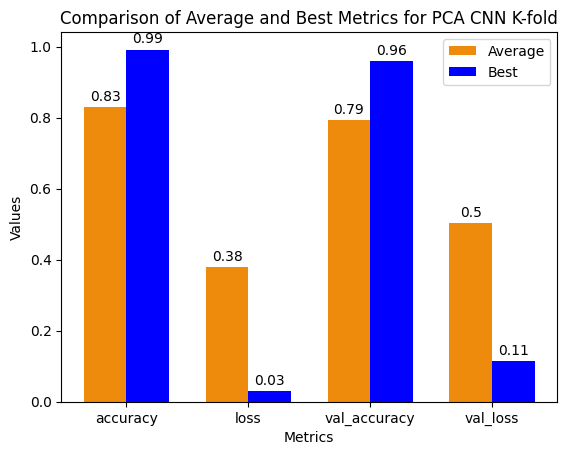

In [15]:
get_history_summary(cnn_history,"PCA CNN K-fold")

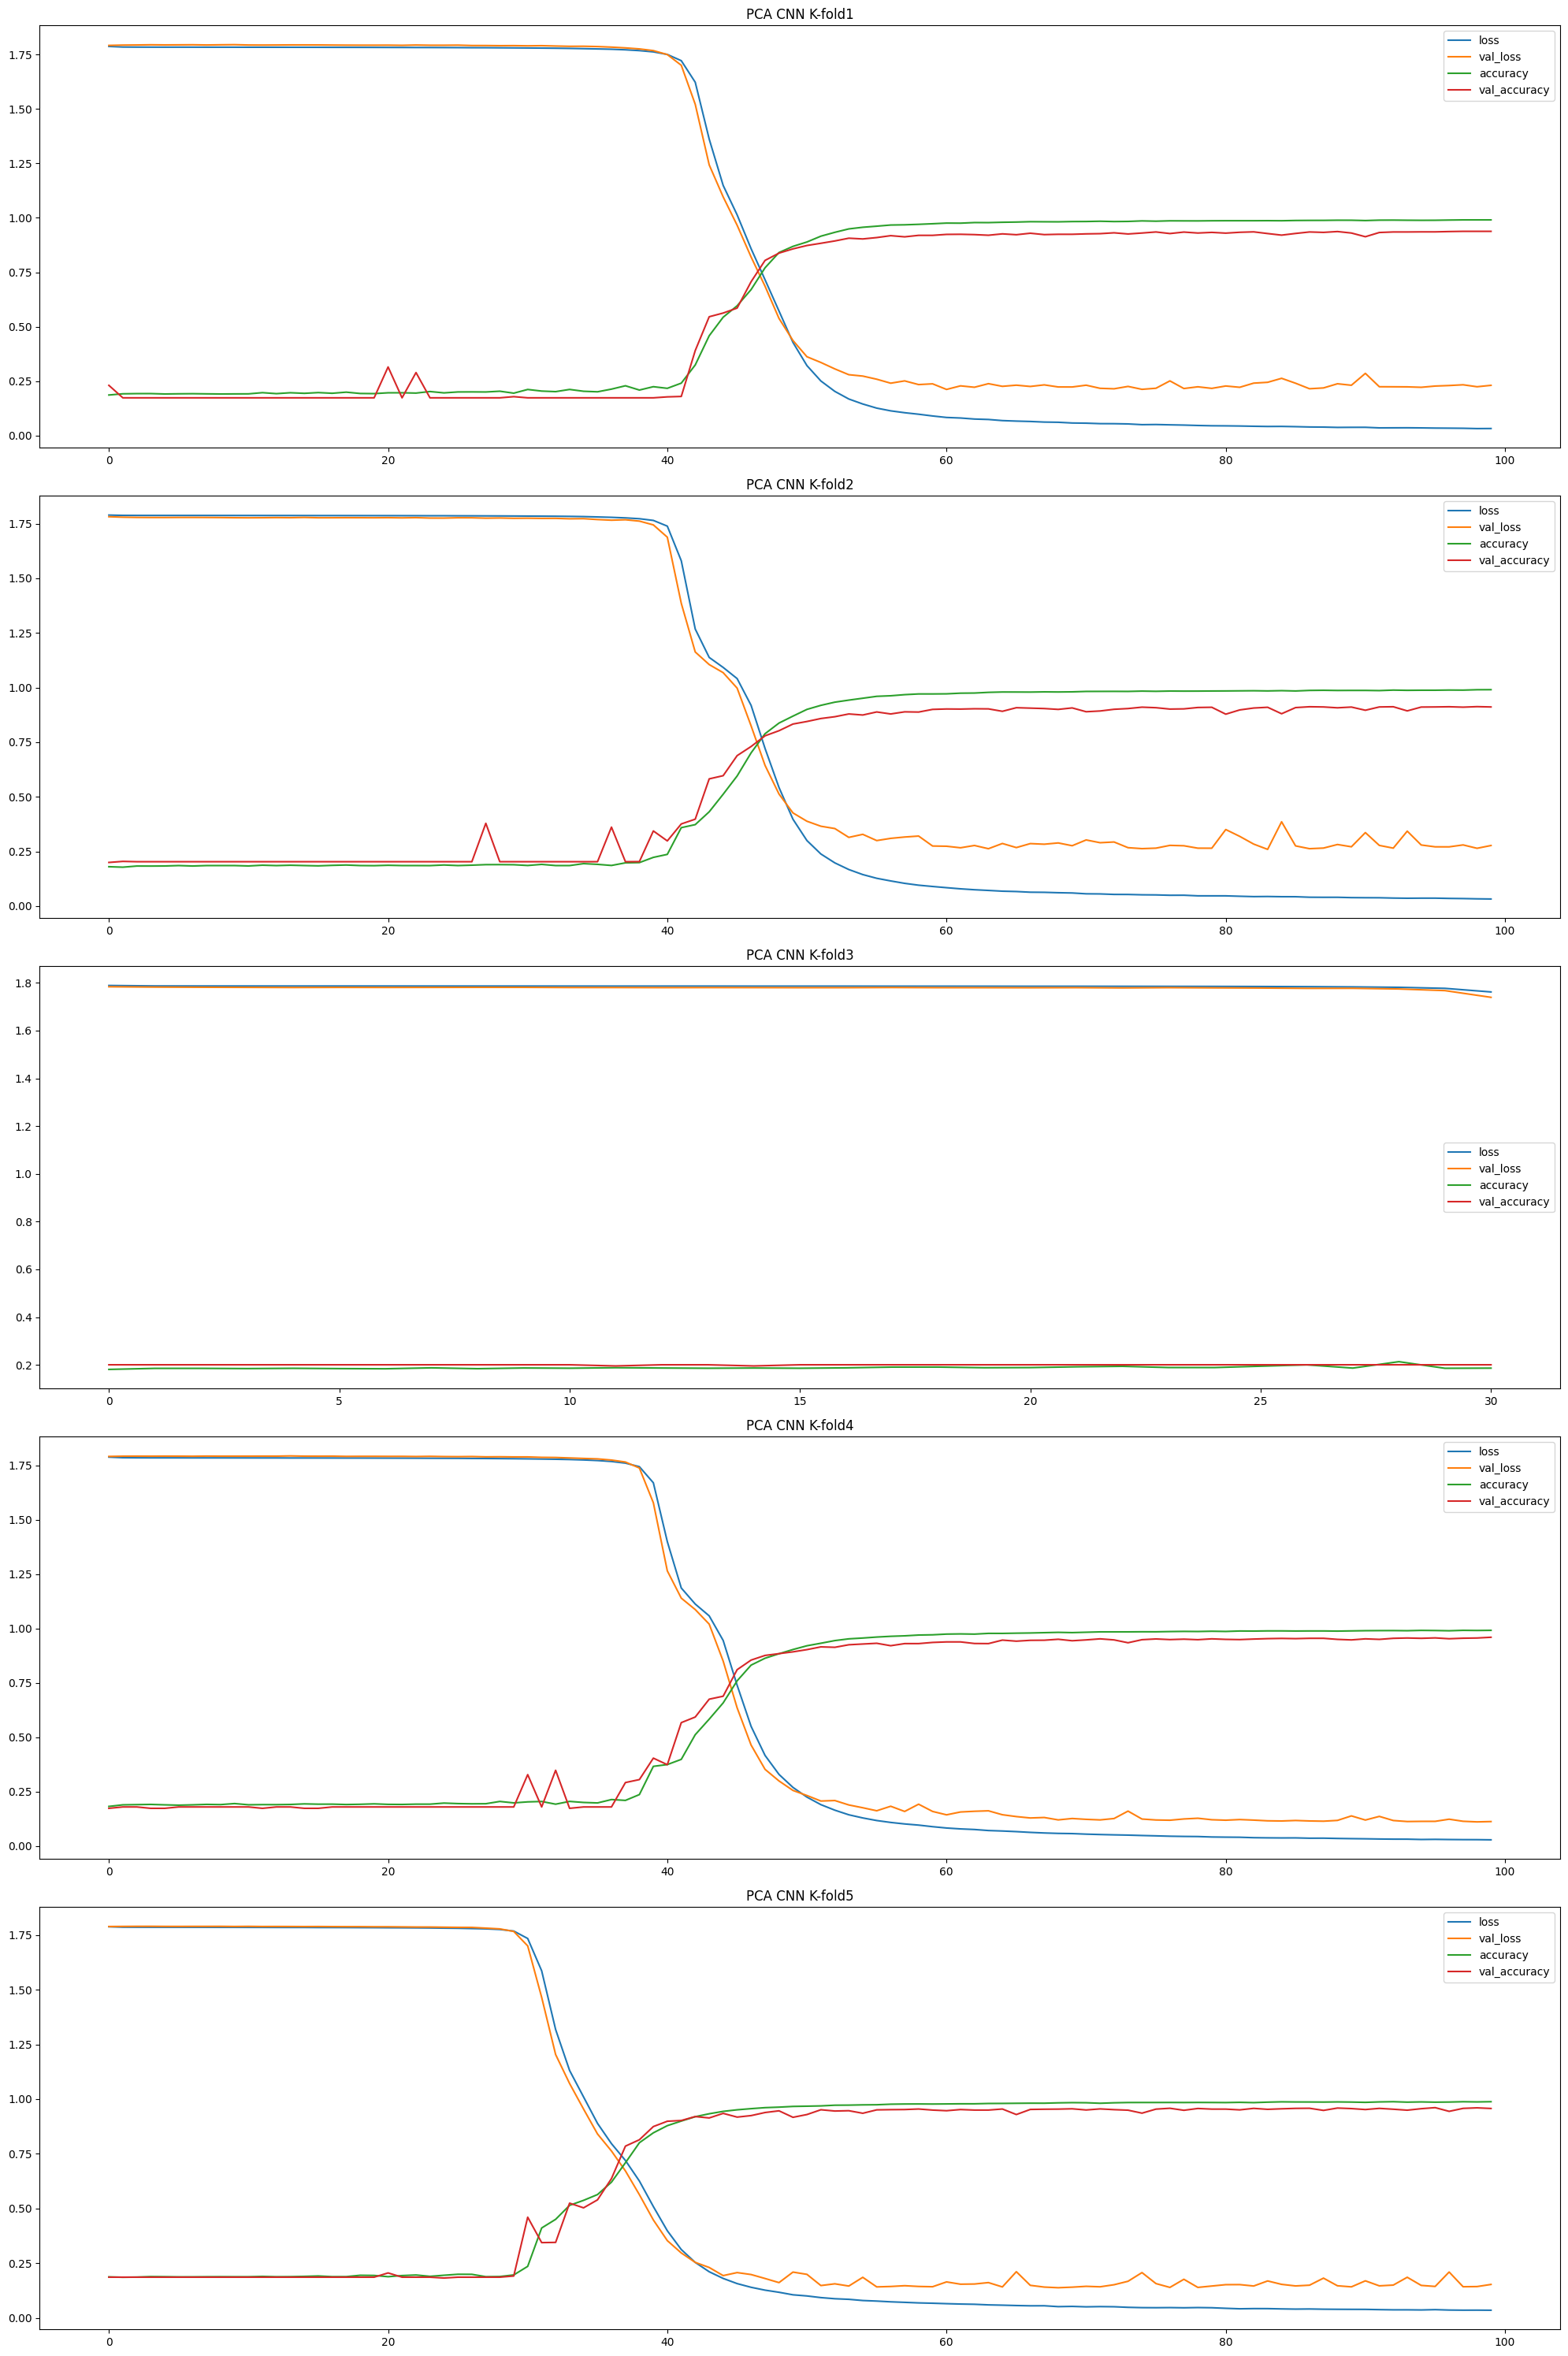

In [16]:
graph_drawing(cnn_history,"PCA CNN K-fold")

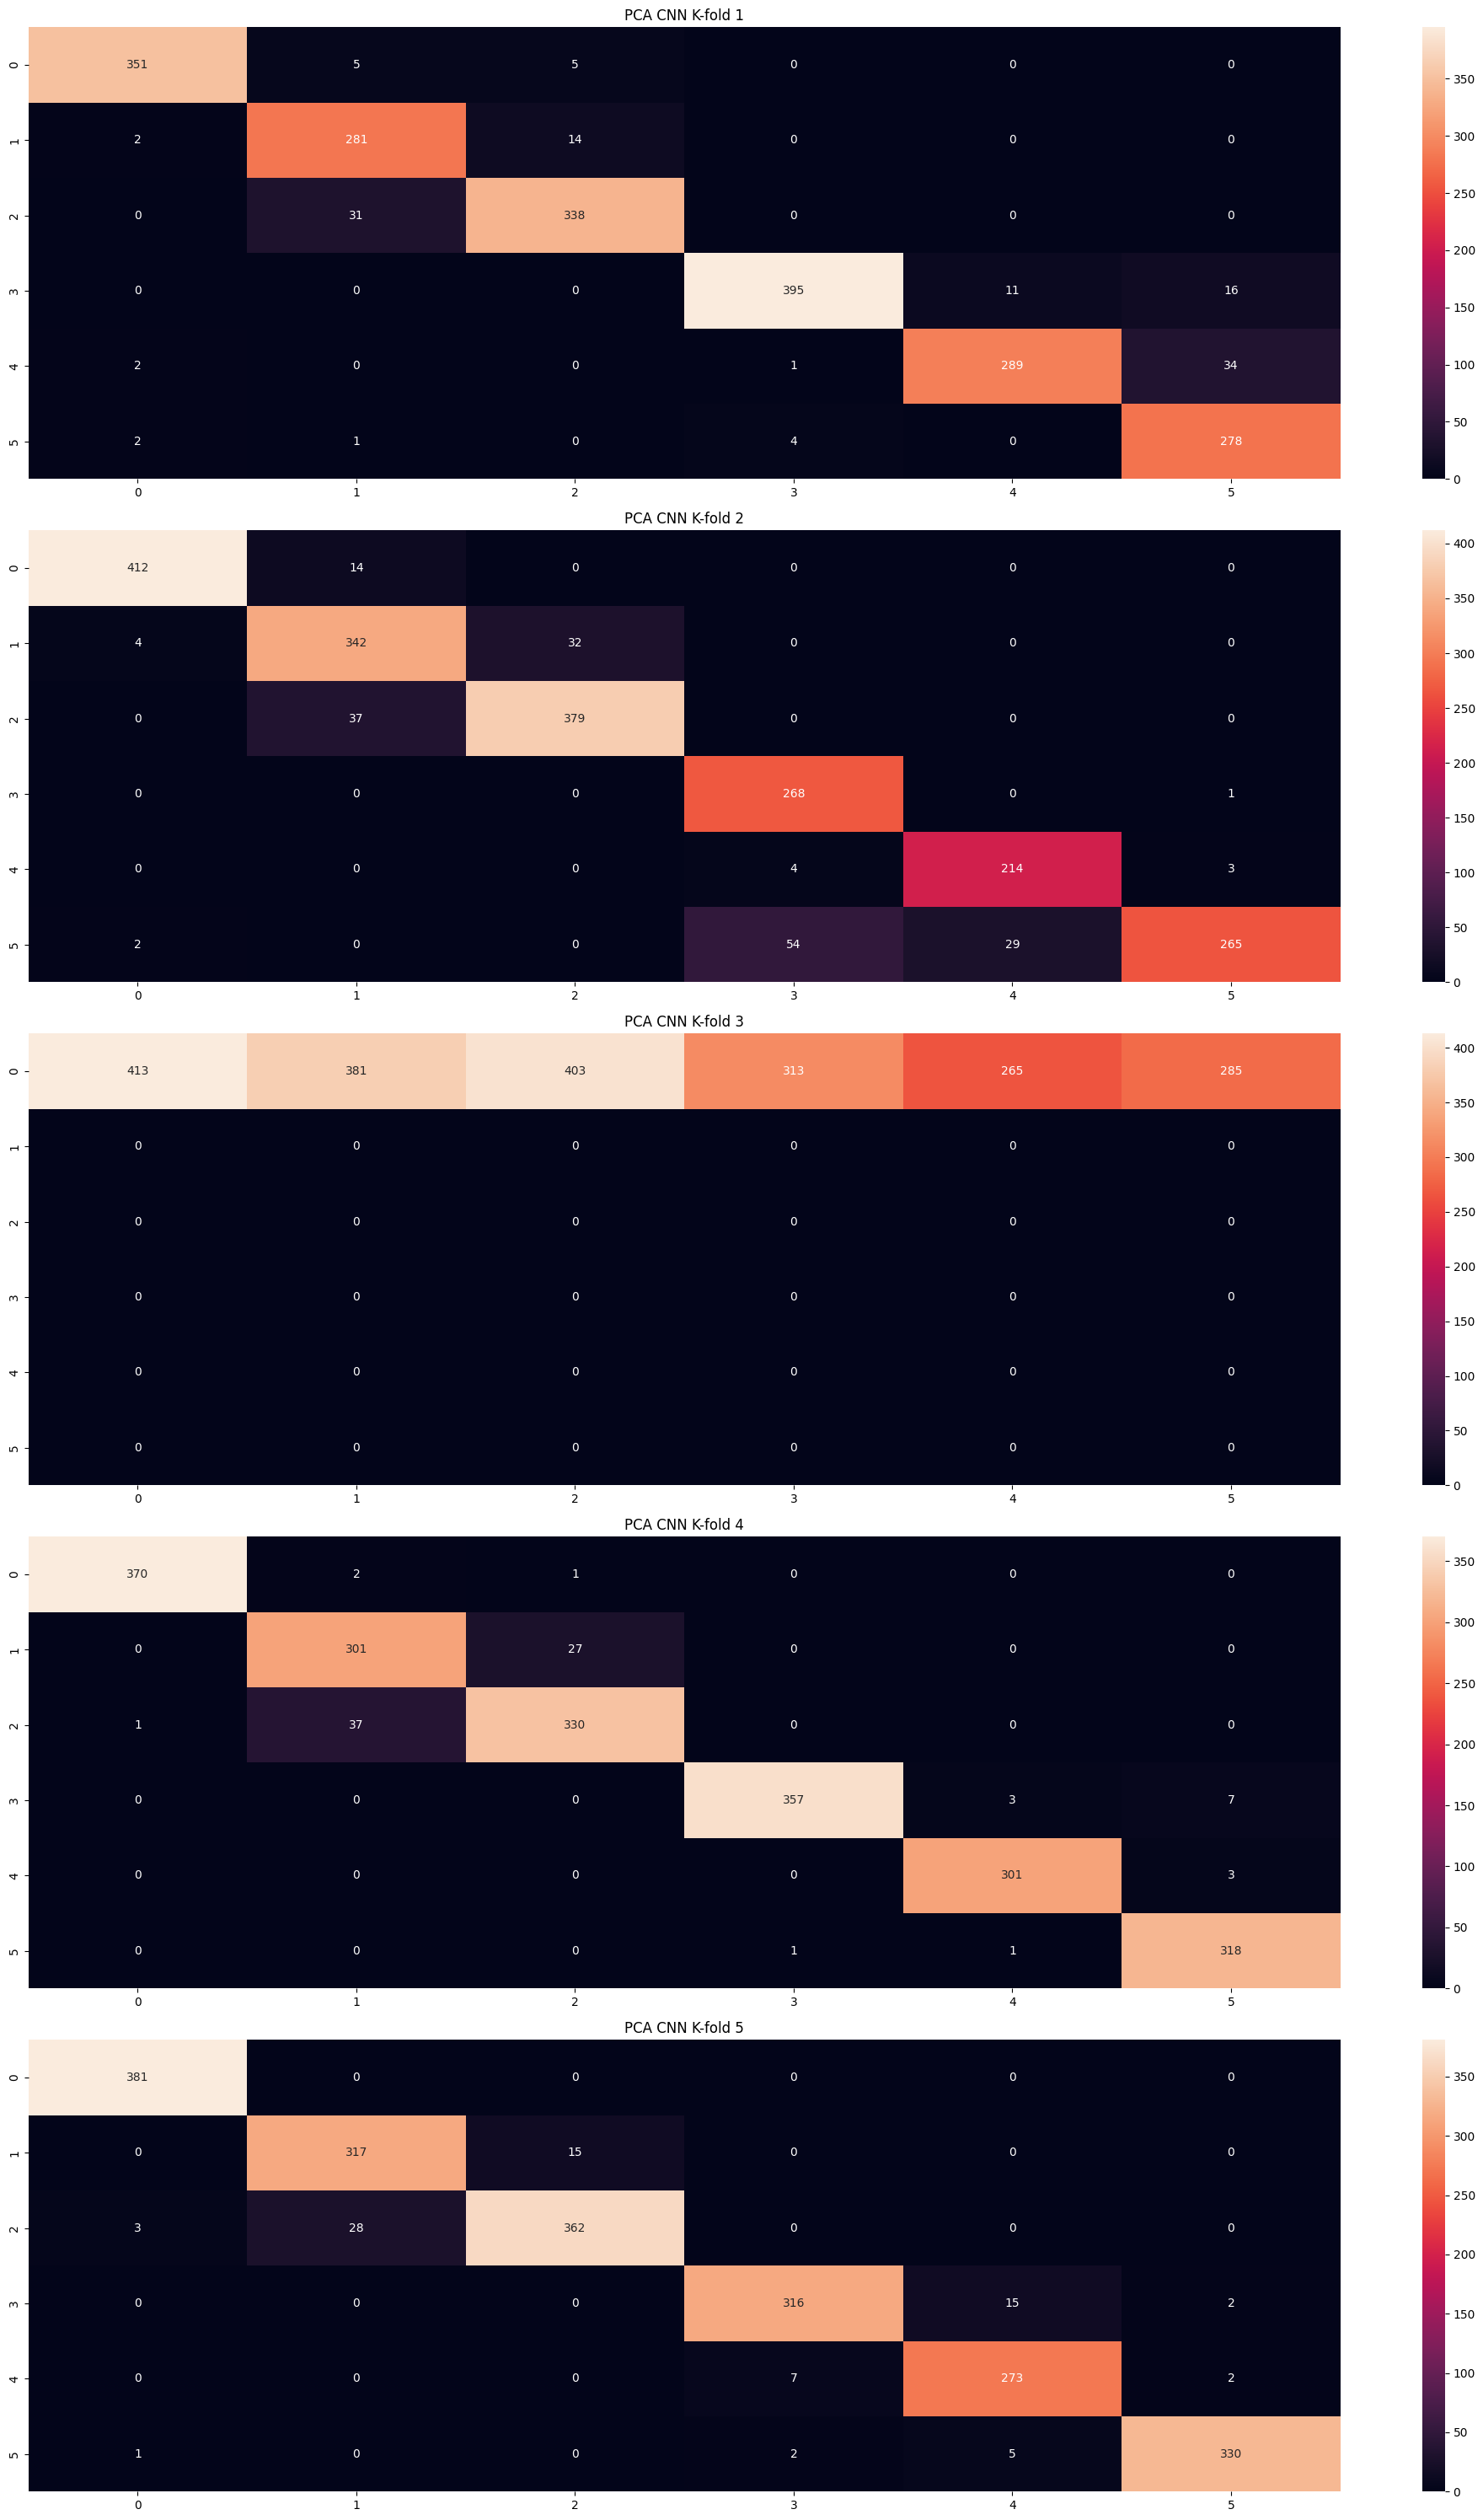

In [17]:
heatmap_drawing(cnn_confusion_matrices,"PCA CNN K-fold")

In [18]:
lstm_history, lstm_confusion_matrices = get_model_performance(model_func= LSTM_Model, X= np_X, y= np_y, epochs=70)

(300, 1)


Model: "LSTM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,558 (60.77 KB)

 Trainable params: 15,558 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.1892 - loss: 1.7895 - val_accuracy: 0.1733 - val_loss: 1.7913
Epoch 2/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.1926 - loss: 1.7860 - val_accuracy: 0.1733 - val_loss: 1.7932
Epoch 3/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.1957 - loss: 1.7821 - val_accuracy: 0.1733 - val_loss: 1.7938
Epoch 4/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.2019 - loss: 1.7826 - val_accuracy: 0.1733 - val_loss: 1.7939
Epoch 5/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.1901 - loss: 1.7825 - val_accuracy: 0.1733 - val_loss: 1.7945
Epoch 6/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.2041 - loss: 1.7809 - val_accuracy: 0.1733 - val_loss: 1.7937
Epoch 7/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.1898 - loss: 1.7828 - val_accuracy: 0.1733 - val_loss: 1.7943
Epoch 8/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.2054 - lo

Model: "LSTM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,558 (60.77 KB)

 Trainable params: 15,558 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - accuracy: 0.1792 - loss: 1.7906 - val_accuracy: 0.2029 - val_loss: 1.7822
Epoch 2/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.1883 - loss: 1.7876 - val_accuracy: 0.1995 - val_loss: 1.7803
Epoch 3/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.1830 - loss: 1.7873 - val_accuracy: 0.2029 - val_loss: 1.7794
Epoch 4/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.1908 - loss: 1.7871 - val_accuracy: 0.2029 - val_loss: 1.7787
Epoch 5/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.1796 - loss: 1.7884 - val_accuracy: 0.2029 - val_loss: 1.7791
Epoch 6/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.1884 - loss: 1.7875 - val_accuracy: 0.2029 - val_loss: 1.7786
Epoch 7/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.1779 - loss: 1.7873 - val_accuracy: 0.2029 - val_loss: 1.7785
Epoch 8/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.1835 - lo

Model: "LSTM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,558 (60.77 KB)

 Trainable params: 15,558 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.1804 - loss: 1.7904 - val_accuracy: 0.2005 - val_loss: 1.7840
Epoch 2/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - accuracy: 0.1817 - loss: 1.7879 - val_accuracy: 0.2005 - val_loss: 1.7822
Epoch 3/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.1821 - loss: 1.7869 - val_accuracy: 0.2005 - val_loss: 1.7814
Epoch 4/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.1955 - loss: 1.7855 - val_accuracy: 0.2005 - val_loss: 1.7808
Epoch 5/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.1850 - loss: 1.7869 - val_accuracy: 0.2005 - val_loss: 1.7811
Epoch 6/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.1758 - loss: 1.7889 - val_accuracy: 0.2005 - val_loss: 1.7810
Epoch 7/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 0.1877 - loss: 1.7870 - val_accuracy: 0.2005 - val_loss: 1.7812
Epoch 8/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 130ms/step - accuracy: 0.1821 - lo

Model: "LSTM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,558 (60.77 KB)

 Trainable params: 15,558 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - accuracy: 0.1946 - loss: 1.7896 - val_accuracy: 0.1801 - val_loss: 1.7897
Epoch 2/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.1912 - loss: 1.7844 - val_accuracy: 0.1801 - val_loss: 1.7906
Epoch 3/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.1828 - loss: 1.7841 - val_accuracy: 0.1801 - val_loss: 1.7910
Epoch 4/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.1992 - loss: 1.7832 - val_accuracy: 0.1738 - val_loss: 1.7911
Epoch 5/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.1874 - loss: 1.7829 - val_accuracy: 0.1801 - val_loss: 1.7914
Epoch 6/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.1894 - loss: 1.7840 - val_accuracy: 0.1801 - val_loss: 1.7918
Epoch 7/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.1852 - loss: 1.7846 - val_accuracy: 0.1801 - val_loss: 1.7919
Epoch 8/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.1956 - lo

Model: "LSTM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,558 (60.77 KB)

 Trainable params: 15,558 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - accuracy: 0.1748 - loss: 1.7897 - val_accuracy: 0.1831 - val_loss: 1.7884
Epoch 2/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.1831 - loss: 1.7862 - val_accuracy: 0.1870 - val_loss: 1.7885
Epoch 3/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.1753 - loss: 1.7842 - val_accuracy: 0.1870 - val_loss: 1.7886
Epoch 4/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.1840 - loss: 1.7848 - val_accuracy: 0.1870 - val_loss: 1.7887
Epoch 5/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.1940 - loss: 1.7841 - val_accuracy: 0.1870 - val_loss: 1.7889
Epoch 6/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.1818 - loss: 1.7860 - val_accuracy: 0.1870 - val_loss: 1.7890
Epoch 7/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.1977 - loss: 1.7844 - val_accuracy: 0.1870 - val_loss: 1.7892
Epoch 8/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.1897 - lo

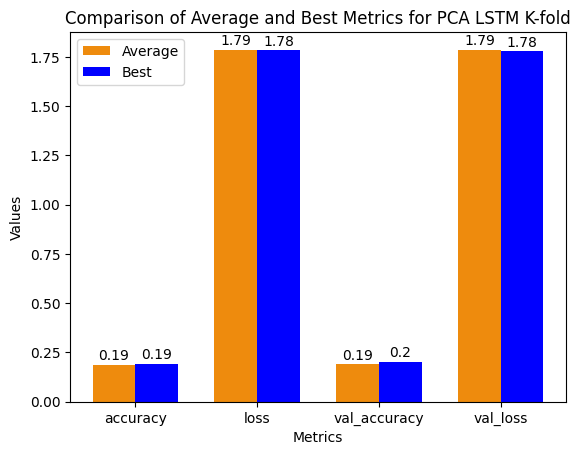

In [19]:
get_history_summary(lstm_history,"PCA LSTM K-fold")

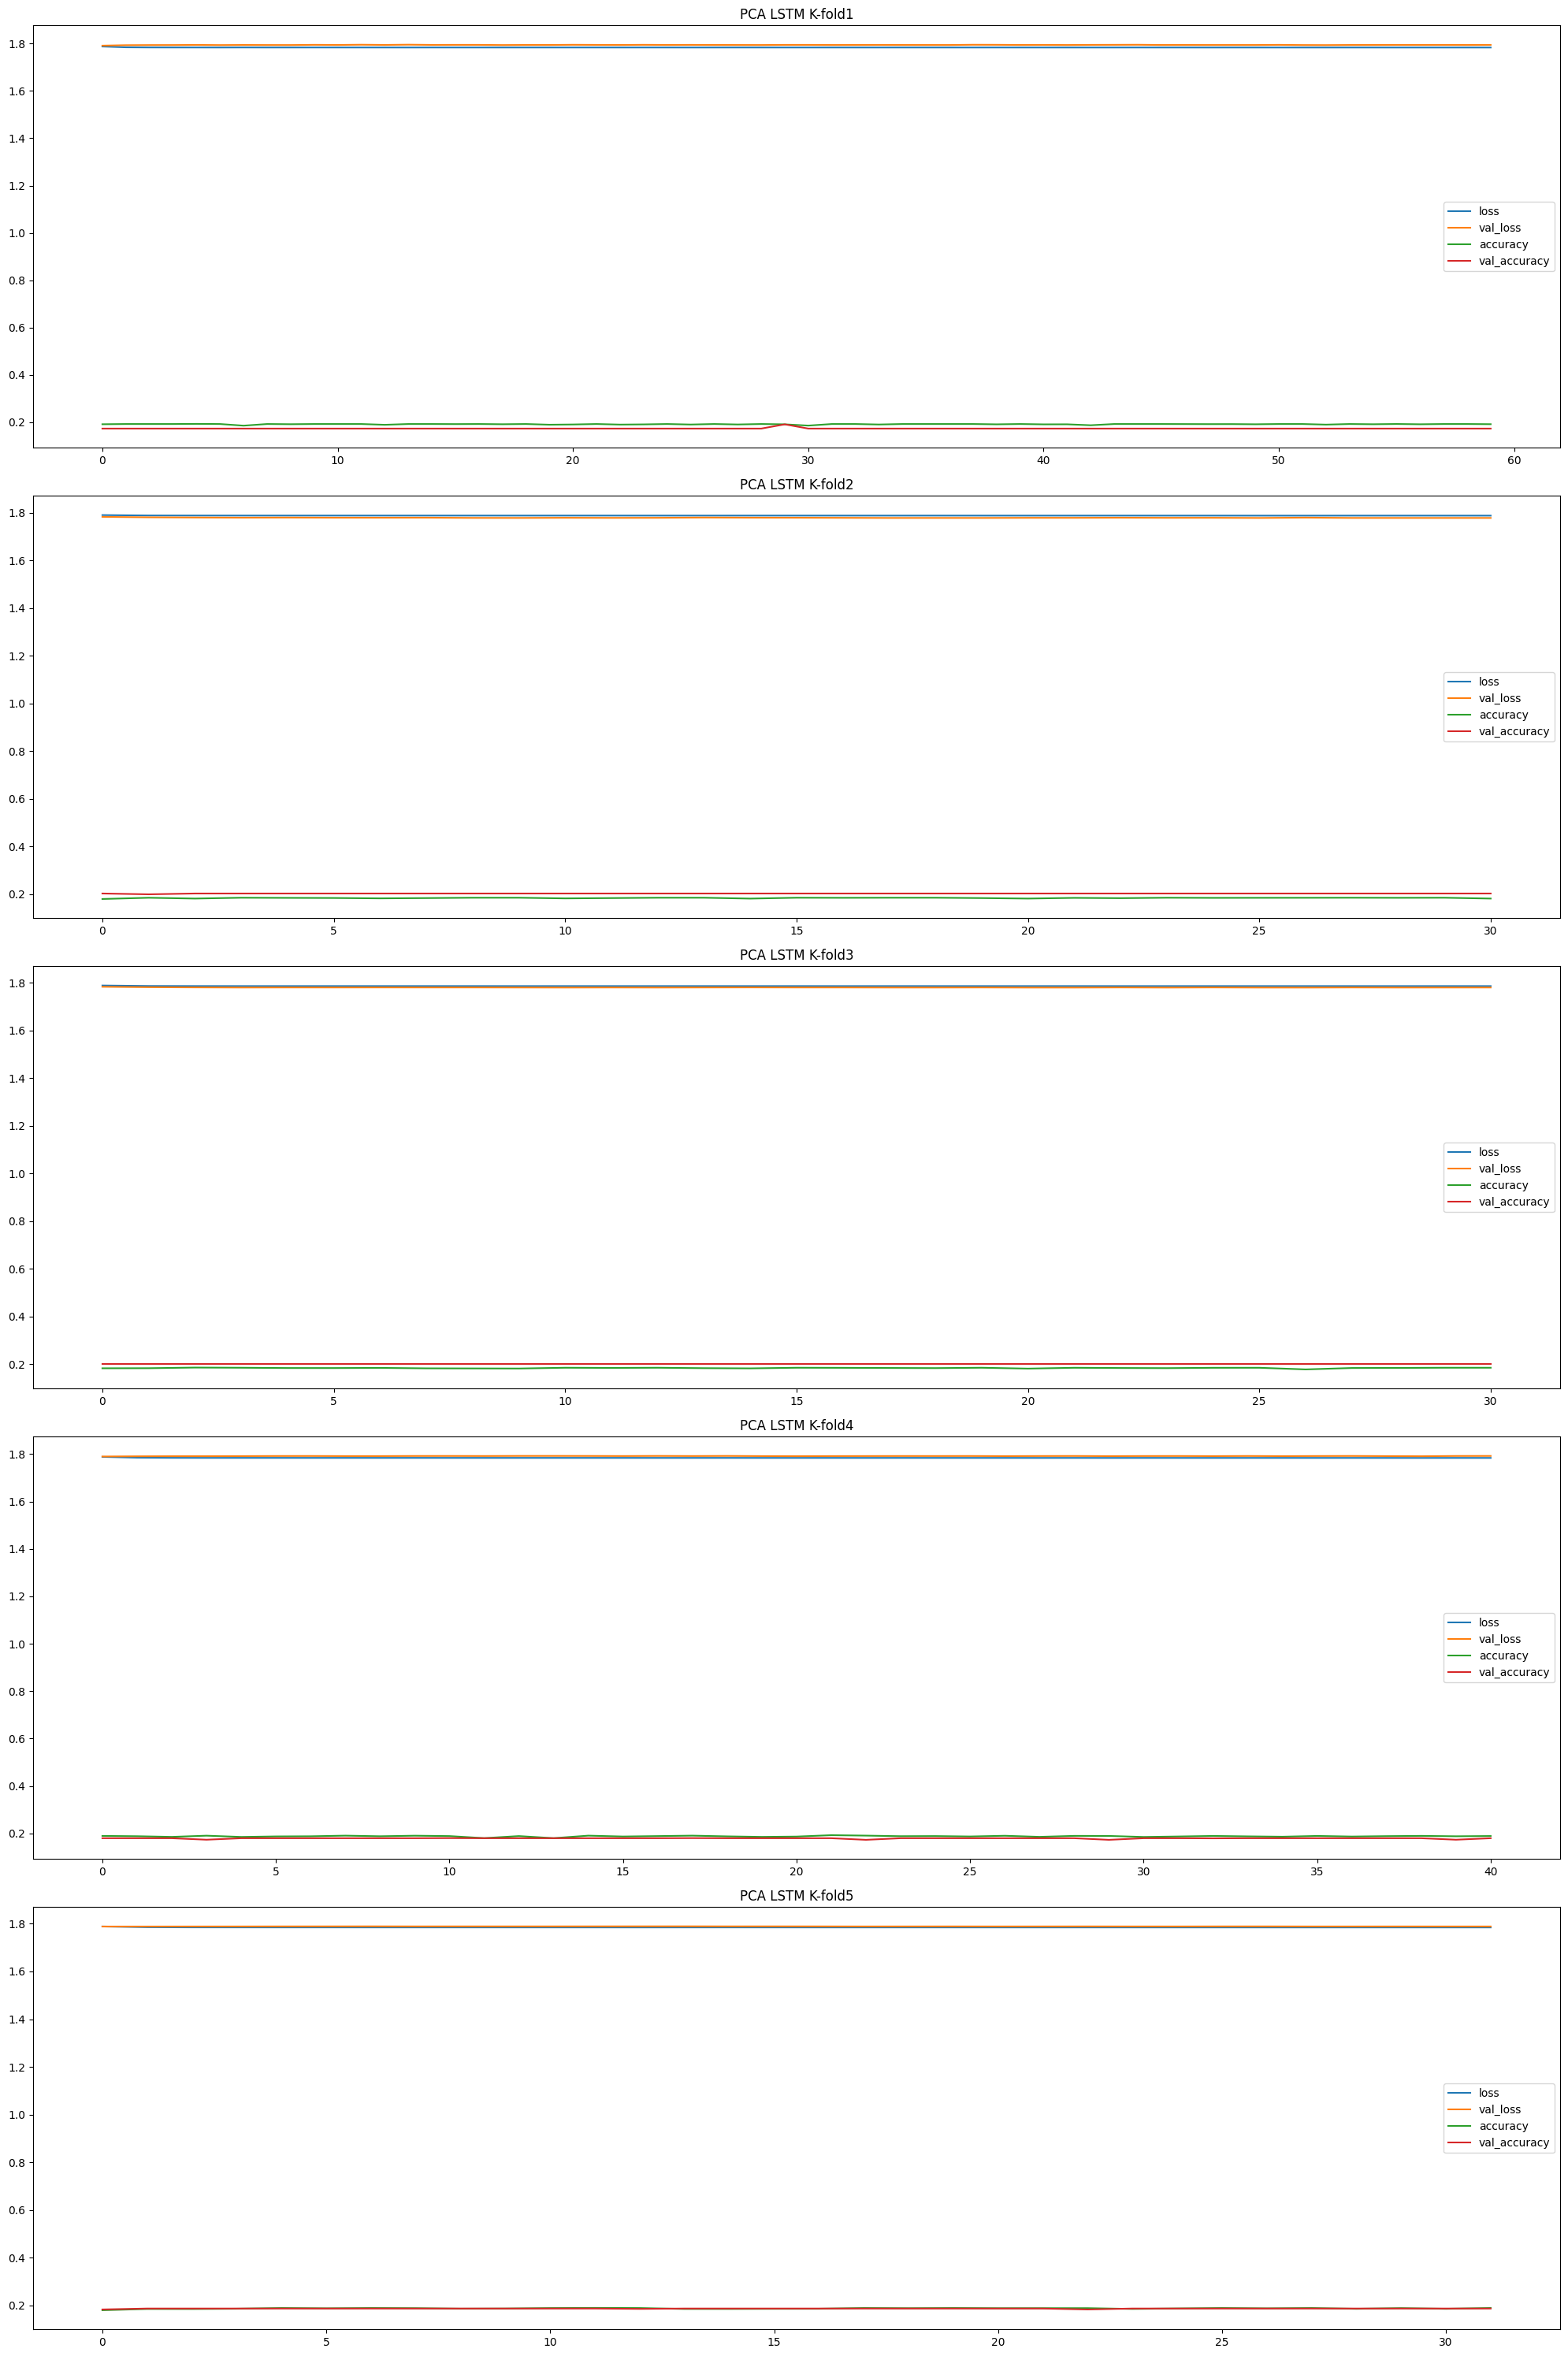

In [20]:
graph_drawing(lstm_history,"PCA LSTM K-fold")

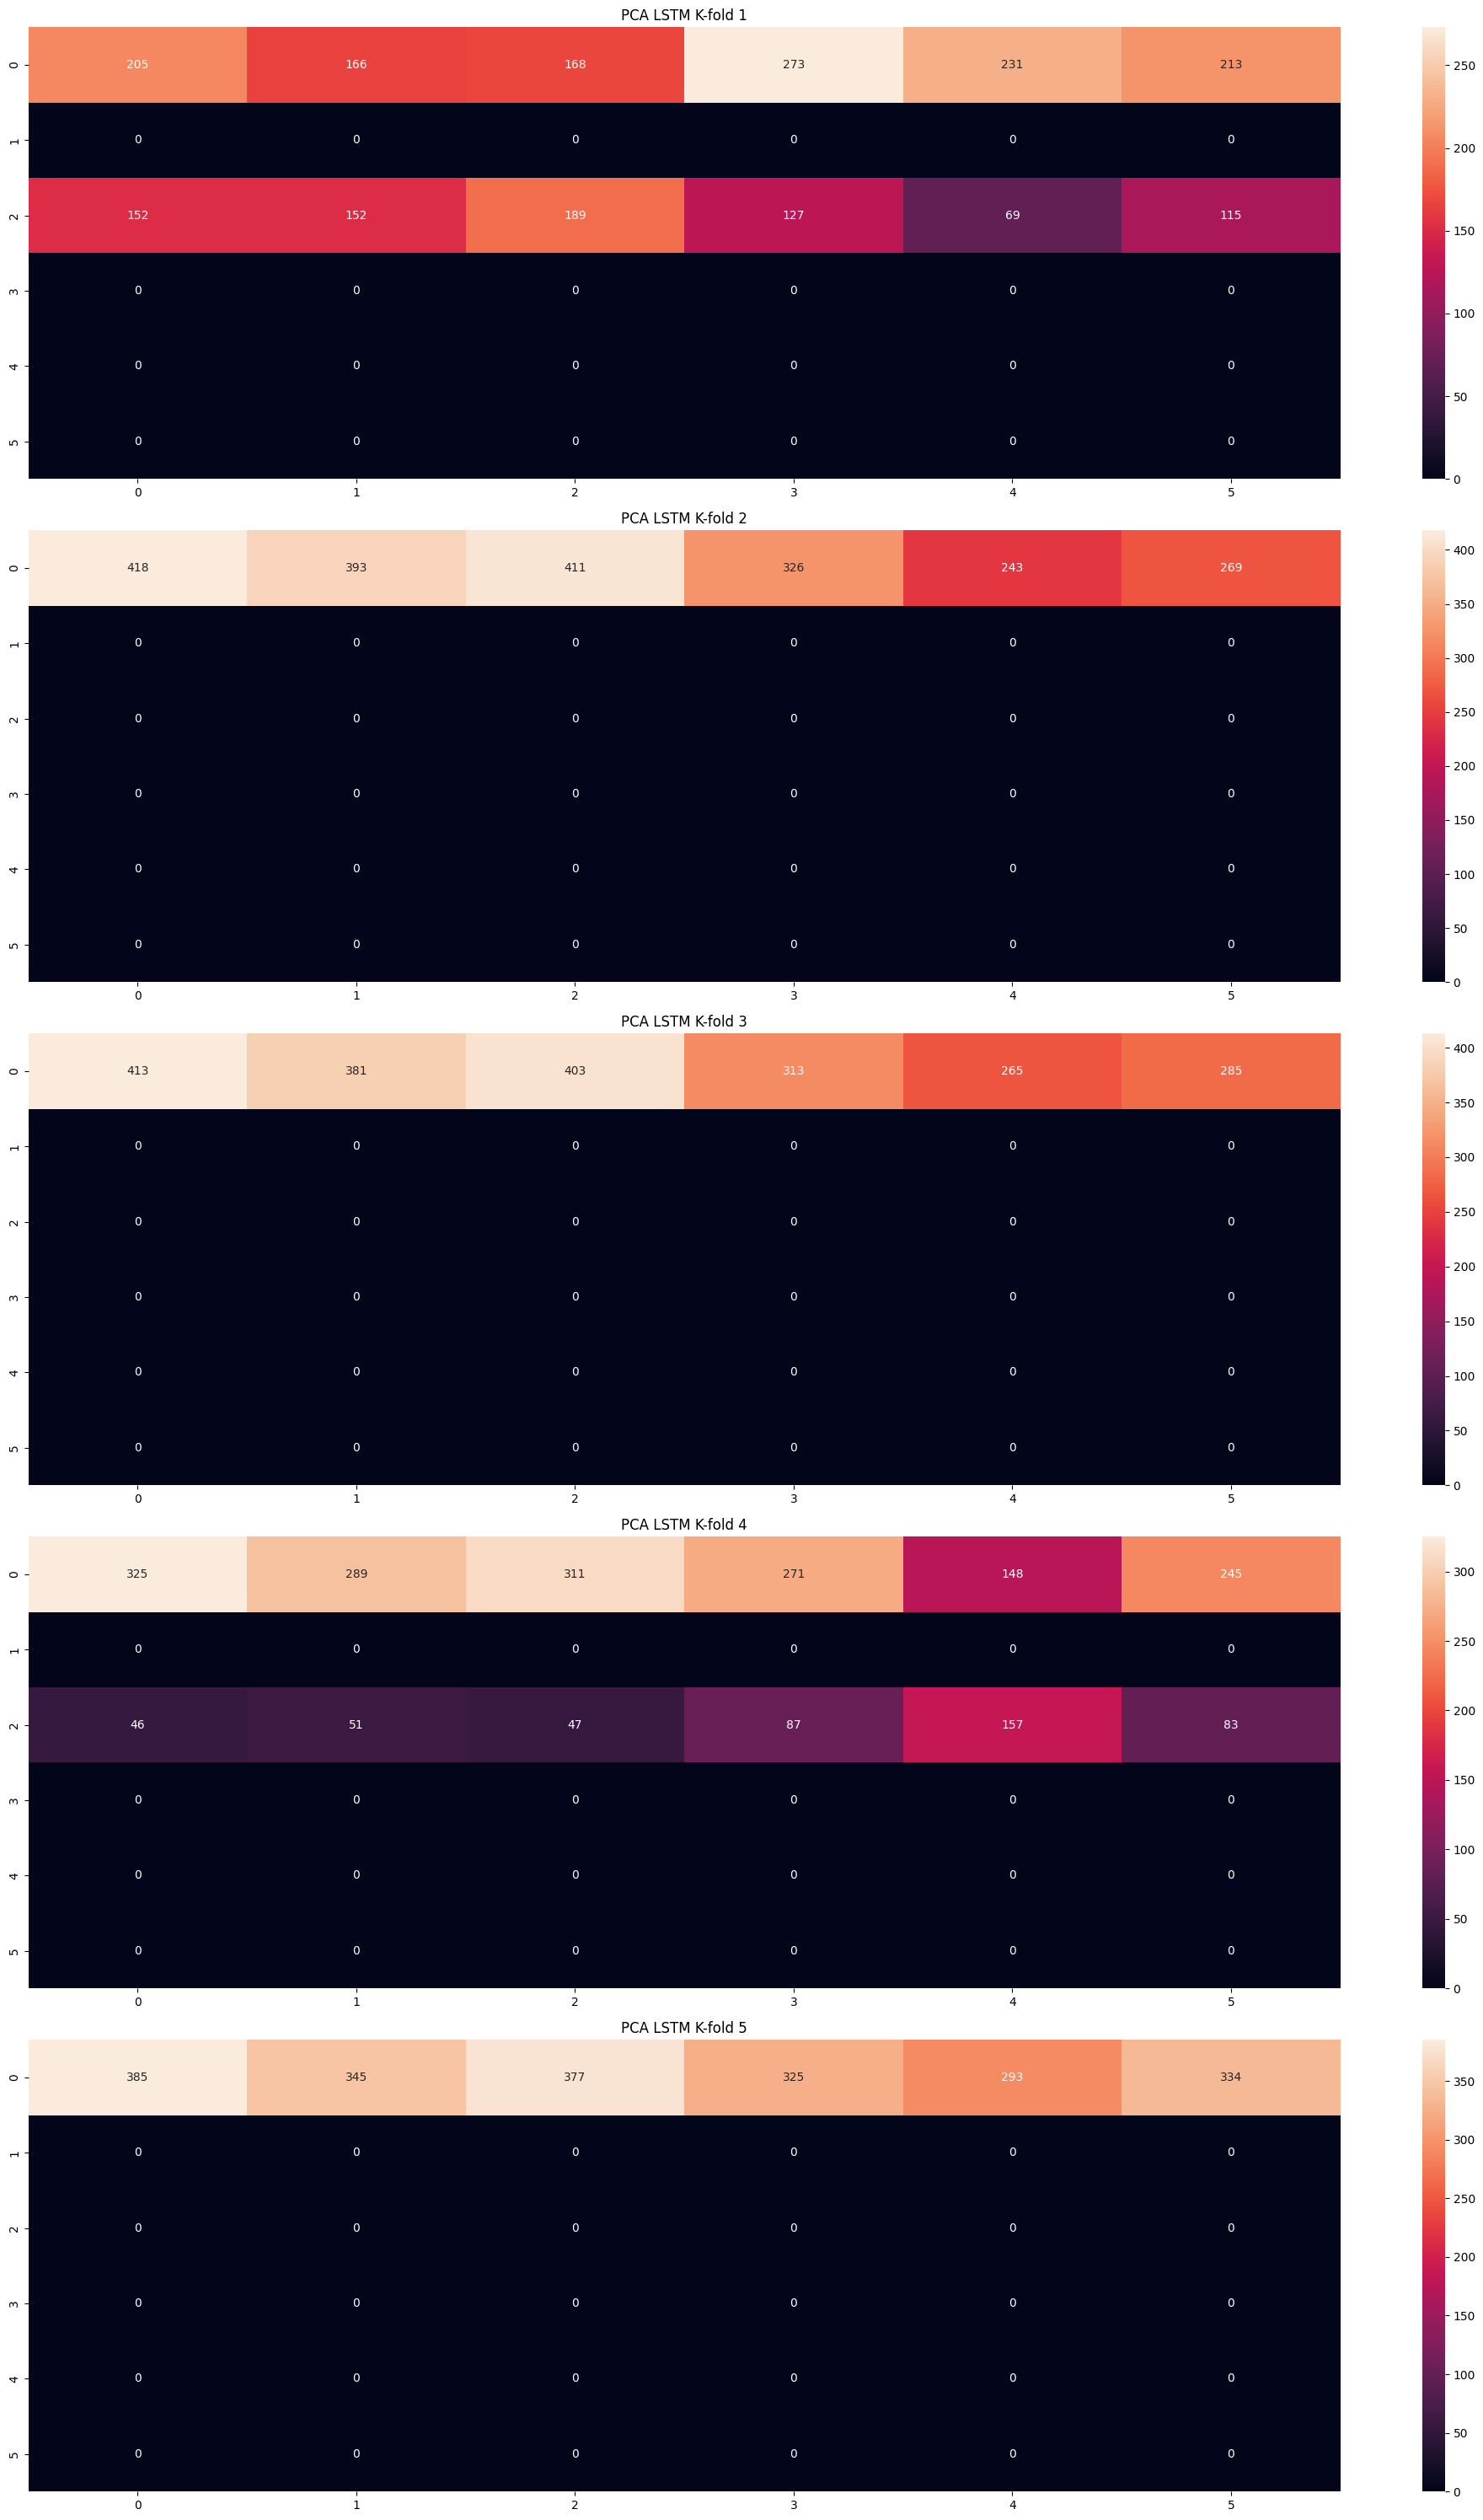

In [21]:
heatmap_drawing(lstm_confusion_matrices, "PCA LSTM K-fold")

In [22]:
cnn_lstm_history, cnn_lstm_confusion_matrices = get_model_performance(model_func= CNN_LSTM_Model, X= np_X, y= np_y, epochs=100)

(300, 1)
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.1902 - loss: 1.7895 - val_accuracy: 0.1733 - val_loss: 1.7913
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.1921 - loss: 1.7841 - val_accuracy: 0.1733 - val_loss: 1.7920
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.1904 - loss: 1.7846 - val_accuracy: 0.1733 - val_loss: 1.7931
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.1908 - loss: 1.7835 - val_accuracy: 0.1733 - val_loss: 1.7931
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 125ms/step - accuracy: 0.1888 - loss: 1.7825 - val_accuracy: 0.1733 - val_loss: 1.7938
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.1928 - loss: 1.7822 - val_accuracy: 0.1733 - val_loss: 1.7937
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.1910 - loss: 1.7841 - val_accuracy: 0.1733 - val_loss: 1.7948
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy:

258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.3263 - loss: 1.4497 - val_accuracy: 0.3641 - val_loss: 1.3418
Epoch 100/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.3539 - loss: 1.3950 - val_accuracy: 0.3544 - val_loss: 1.3436
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
(300, 1)
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.1808 - loss: 1.7905 - val_accuracy: 0.2029 - val_loss: 1.7828
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.1820 - loss: 1.7885 - val_accuracy: 0.2029 - val_loss: 1.7798
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.1817 - loss: 1.7883 - val_accuracy: 0.2029 - val_loss: 1.7784
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.1782 - loss: 1.7880 - val_accuracy: 0.2029 - val_loss: 1.7783
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.1872 - loss: 1.7862 - val_accuracy: 0.2029 - val_loss: 1.7780
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━

Epoch 48/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.1984 - loss: 1.7736 - val_accuracy: 0.2034 - val_loss: 1.7760
Epoch 49/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.1945 - loss: 1.7781 - val_accuracy: 0.2039 - val_loss: 1.7711
Epoch 50/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.1924 - loss: 1.7767 - val_accuracy: 0.2029 - val_loss: 1.7704
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.1919 - loss: 1.7825 - val_accuracy: 0.2184 - val_loss: 1.7599
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.2093 - loss: 1.7652 - val_accuracy: 0.2417 - val_loss: 1.7331
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.2219 - loss: 1.7572 - val_accuracy: 0.2752 - val_loss: 1.7284
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.2091 - loss: 1.7627 - val_accuracy: 0.2199 - val_loss: 1.7538
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.2036 -

258/258 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.1952 - loss: 1.7829 - val_accuracy: 0.1738 - val_loss: 1.7920
Epoch 15/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.1857 - loss: 1.7826 - val_accuracy: 0.1801 - val_loss: 1.7906
Epoch 16/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.1879 - loss: 1.7836 - val_accuracy: 0.1728 - val_loss: 1.7916
Epoch 17/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.1995 - loss: 1.7824 - val_accuracy: 0.1801 - val_loss: 1.7901
Epoch 18/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.1944 - loss: 1.7813 - val_accuracy: 0.1801 - val_loss: 1.7912
Epoch 19/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.1940 - loss: 1.7818 - val_accuracy: 0.1801 - val_loss: 1.7903
Epoch 20/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.1933 - loss: 1.7819 - val_accuracy: 0.1752 - val_loss: 1.7902
Epoch 21/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.1972 - loss: 1.7

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


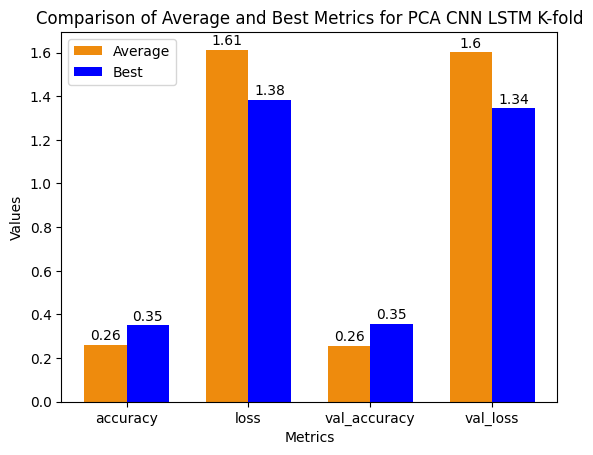

In [23]:
get_history_summary(cnn_lstm_history,"PCA CNN LSTM K-fold")

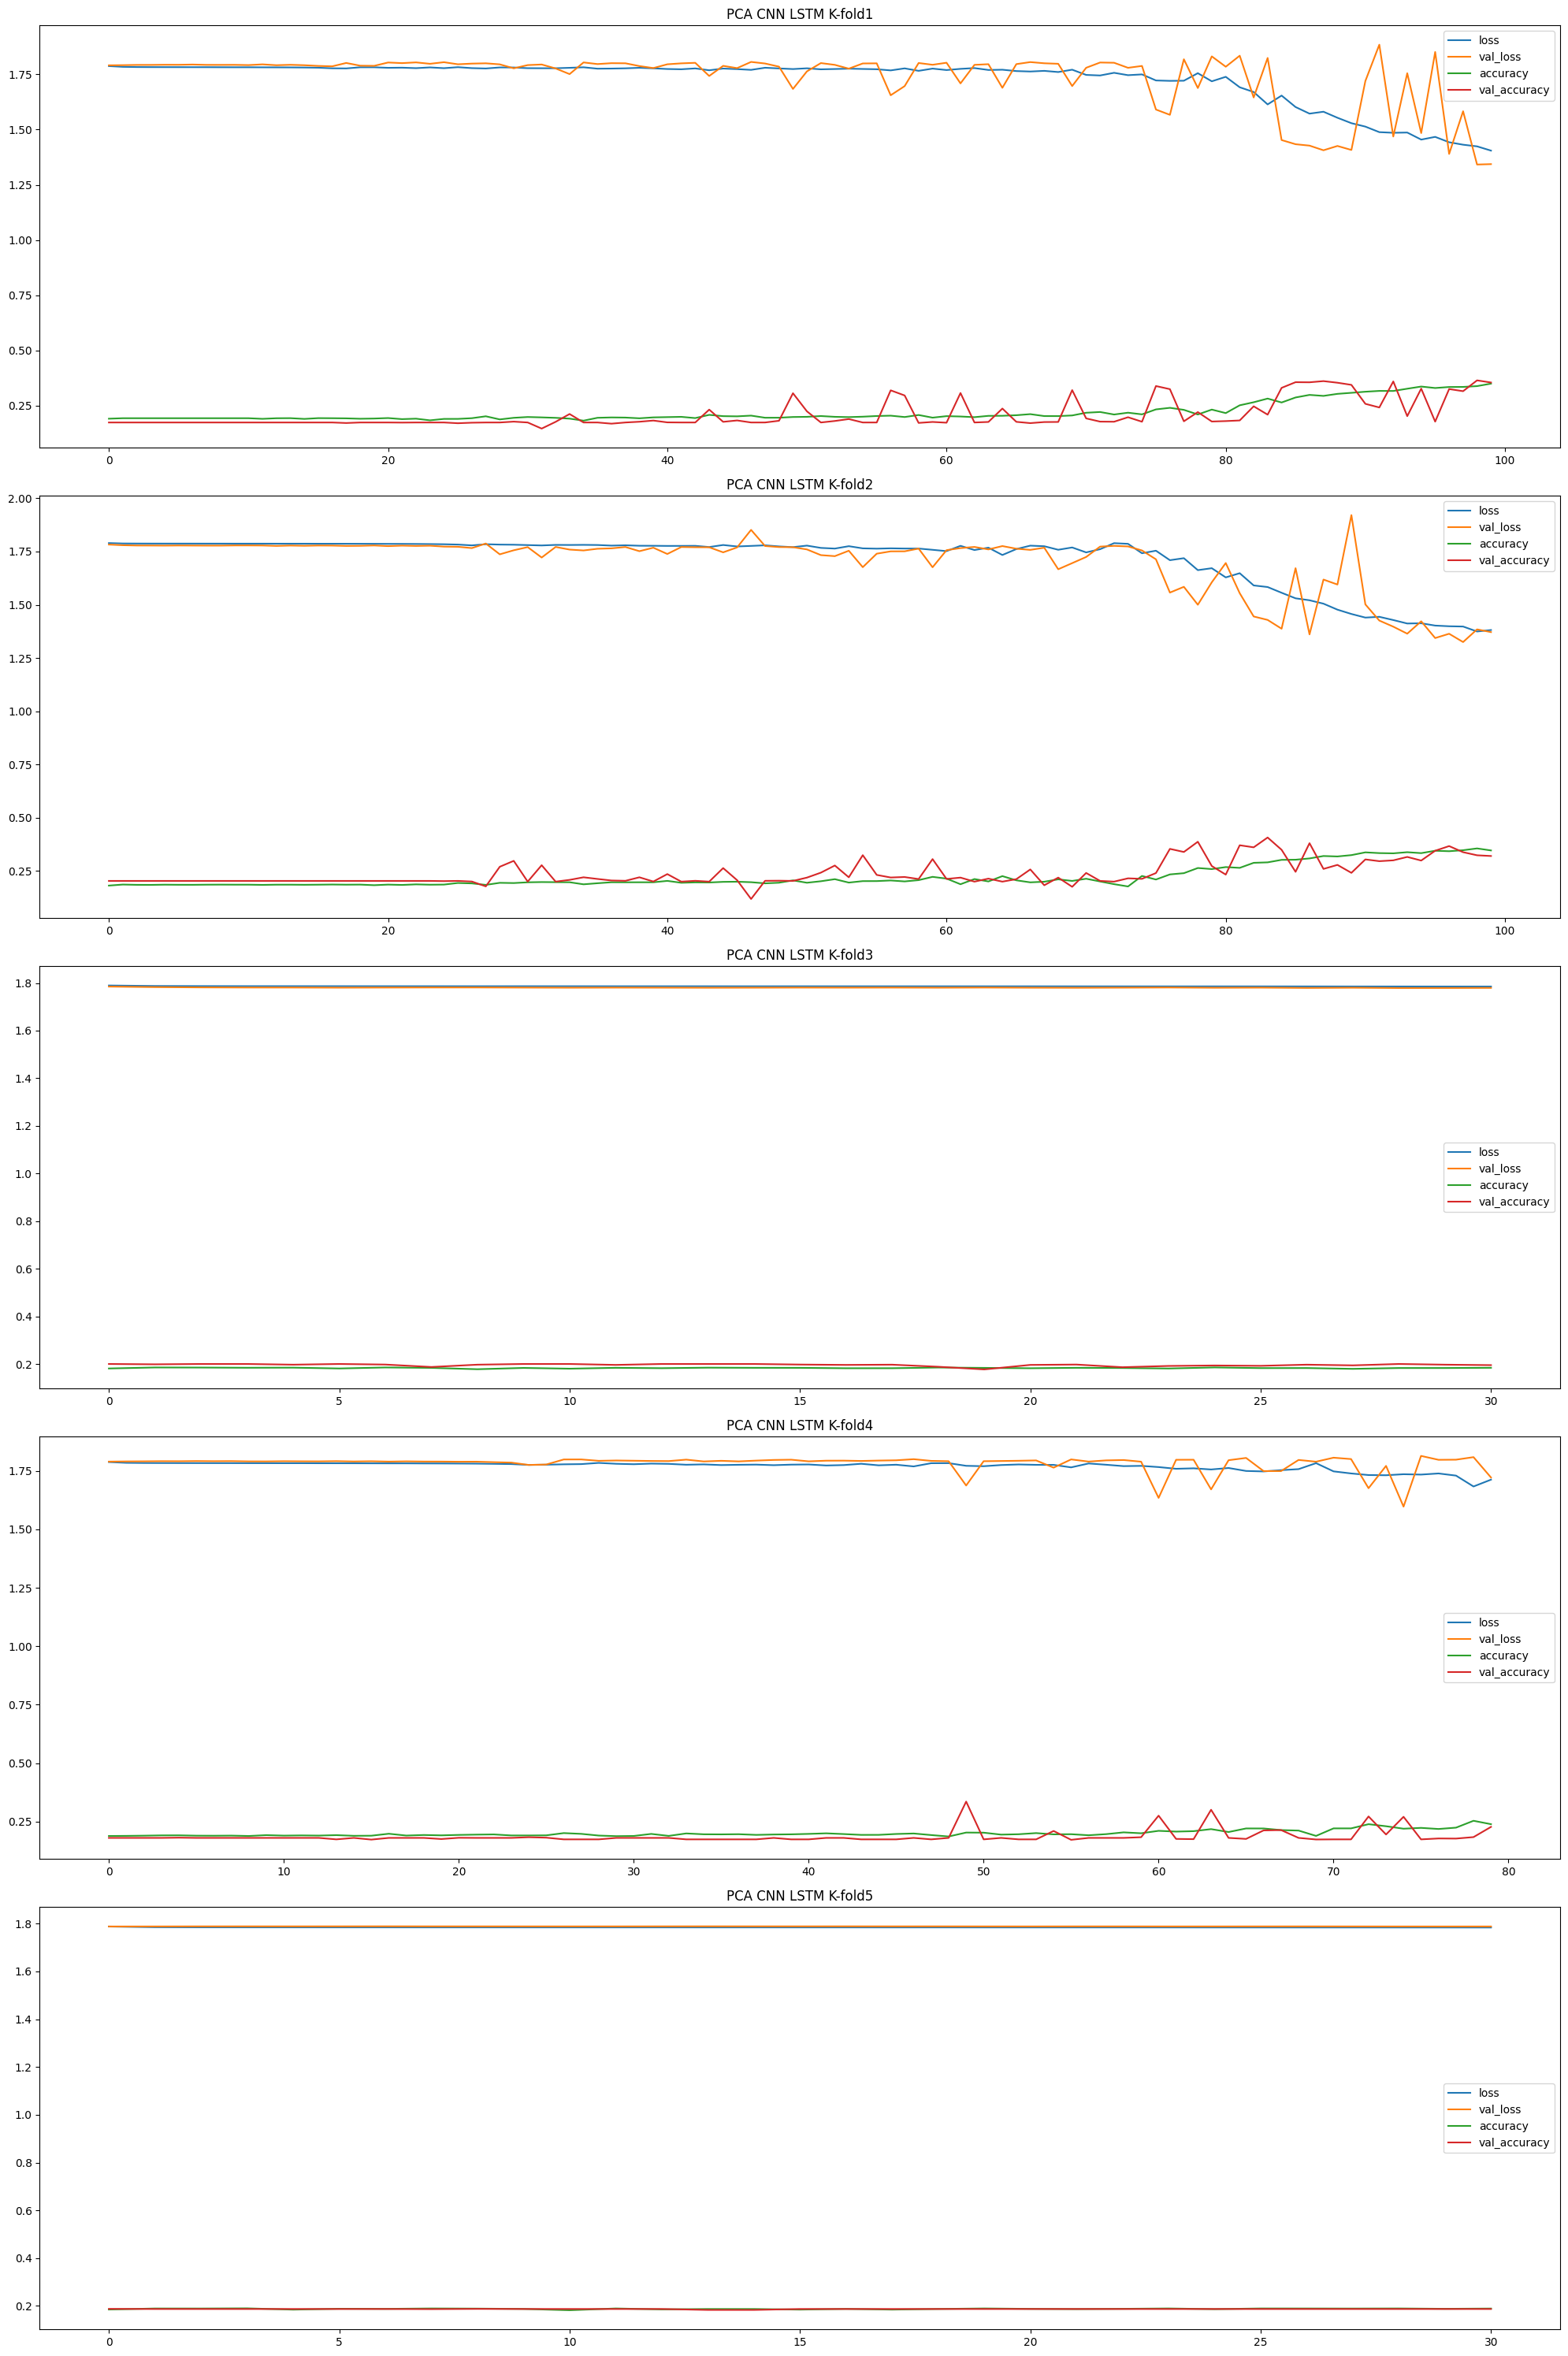

In [24]:
graph_drawing(cnn_lstm_history,"PCA CNN LSTM K-fold")

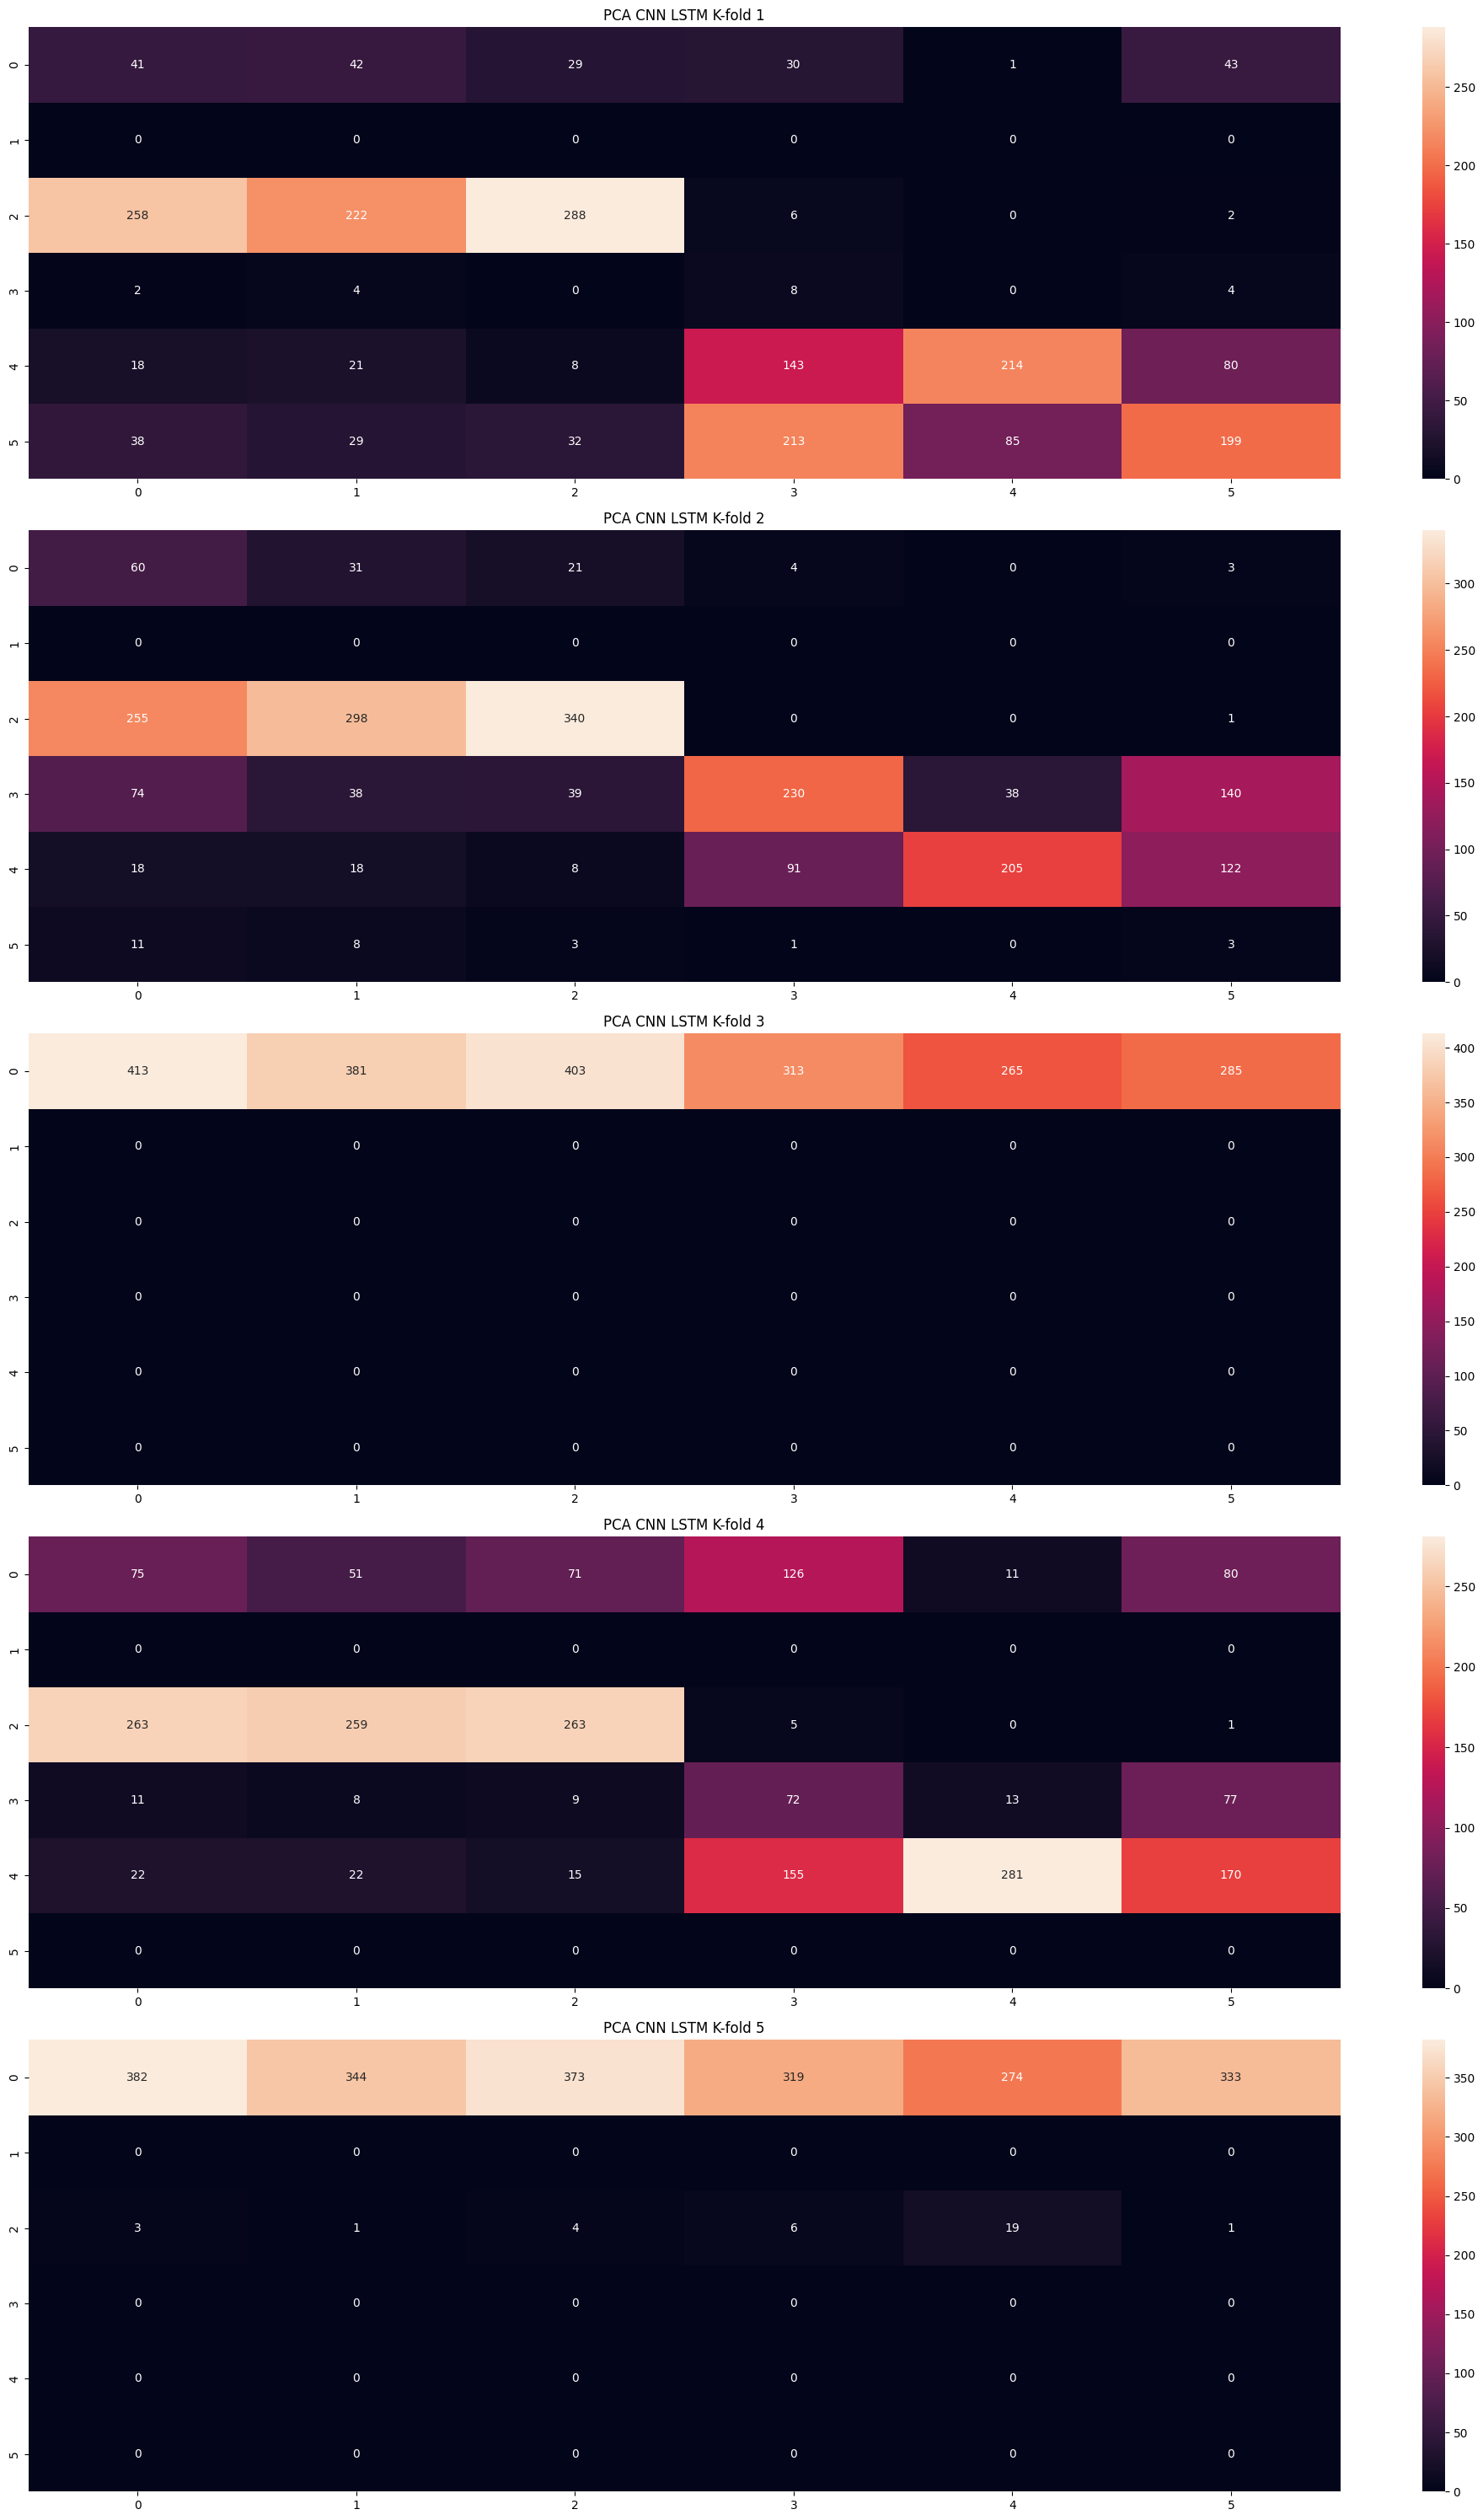

In [25]:
heatmap_drawing(cnn_lstm_confusion_matrices,"PCA CNN LSTM K-fold")

In [30]:
def save_history(filename, history):
    np_history = []
    for i in range(len(history)):
        his = history[i]
        np_history.append(his.history)
    np.save(filename, np_history)

In [31]:
save_history("cnn_lstm_history.npy",cnn_lstm_history)

In [32]:
save_history("lstm_history.npy",lstm_history)

In [33]:
save_history("cnn_history.np",cnn_history)

In [35]:
def FDDLM_Model(data):
    model = keras.Sequential(name="FDDLM_Sequential")
    print(data.shape[1:])
    model.add( layers.Input(shape=data.shape[1:]) )
    model.add( layers.Dense(300, activation='relu', name="Dense_1"))
    model.add(layers.Flatten())
    model.add( layers.Dense(100, activation='relu', name="Dense_2"))
    model.add( layers.Dense(6, activation='softmax', name='output'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

In [36]:
fddlm_history, fddlm_confusion_matrices = get_model_performance(model_func= FDDLM_Model, X= np_X, y= np_y, epochs=100)

(300, 1)


Model: "FDDLM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 300, 300)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 100)            │     9,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,306 (34.34 MB)

 Trainable params: 9,001,306 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6191 - loss: 1.1809 - val_accuracy: 0.8714 - val_loss: 0.4704
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9023 - loss: 0.3674 - val_accuracy: 0.9301 - val_loss: 0.2700
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9364 - loss: 0.2145 - val_accuracy: 0.9262 - val_loss: 0.2173
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9574 - loss: 0.1583 - val_accuracy: 0.9248 - val_loss: 0.2089
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9728 - loss: 0.1145 - val_accuracy: 0.9277 - val_loss: 0.1966
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9730 - loss: 0.0973 - val_accuracy: 0.9408 - val_loss: 0.1779
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9768 - loss: 0.0899 - val_accuracy: 0.9301 - val_loss: 0.1782
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9742 - loss: 0.08

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9934 - loss: 0.0206 - val_accuracy: 0.9558 - val_loss: 0.1639
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9953 - loss: 0.0181 - val_accuracy: 0.9534 - val_loss: 0.1672
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9928 - loss: 0.0206 - val_accuracy: 0.9427 - val_loss: 0.1971
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9924 - loss: 0.0224 - val_accuracy: 0.9476 - val_loss: 0.1853
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9925 - loss: 0.0214 - val_accuracy: 0.9539 - val_loss: 0.1666
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9943 - loss: 0.0190 - val_accuracy: 0.9544 - val_loss: 0.1683
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9364 - val_loss: 0.2127
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9920 - loss: 0.0204 - val_a

Model: "FDDLM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 300, 300)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 100)            │     9,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,306 (34.34 MB)

 Trainable params: 9,001,306 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6375 - loss: 1.1632 - val_accuracy: 0.8053 - val_loss: 0.4779
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9136 - loss: 0.3438 - val_accuracy: 0.8665 - val_loss: 0.3117
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9472 - loss: 0.2005 - val_accuracy: 0.8903 - val_loss: 0.2736
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9627 - loss: 0.1405 - val_accuracy: 0.8908 - val_loss: 0.2509
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9716 - loss: 0.1168 - val_accuracy: 0.9044 - val_loss: 0.2343
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9725 - loss: 0.0970 - val_accuracy: 0.8728 - val_loss: 0.2702
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9761 - loss: 0.0843 - val_accuracy: 0.9112 - val_loss: 0.2355
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9748 - loss: 0.07

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9933 - loss: 0.0202 - val_accuracy: 0.9272 - val_loss: 0.2238
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9937 - loss: 0.0198 - val_accuracy: 0.9272 - val_loss: 0.2324
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9935 - loss: 0.0197 - val_accuracy: 0.9345 - val_loss: 0.2127
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9936 - loss: 0.0197 - val_accuracy: 0.9277 - val_loss: 0.2226
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9932 - loss: 0.0214 - val_accuracy: 0.9320 - val_loss: 0.2318
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9952 - loss: 0.0174 - val_accuracy: 0.9325 - val_loss: 0.2251
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9928 - loss: 0.0202 - val_accuracy: 0.9316 - val_loss: 0.2240
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9951 - loss: 0.0180 - val_a

Model: "FDDLM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 300, 300)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 100)            │     9,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,306 (34.34 MB)

 Trainable params: 9,001,306 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5878 - loss: 1.1941 - val_accuracy: 0.8937 - val_loss: 0.4348
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9009 - loss: 0.3693 - val_accuracy: 0.9136 - val_loss: 0.2580
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9310 - loss: 0.2264 - val_accuracy: 0.9320 - val_loss: 0.1990
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9497 - loss: 0.1634 - val_accuracy: 0.9374 - val_loss: 0.1699
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9656 - loss: 0.1263 - val_accuracy: 0.9422 - val_loss: 0.1574
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9652 - loss: 0.1115 - val_accuracy: 0.9461 - val_loss: 0.1459
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9681 - loss: 0.0969 - val_accuracy: 0.9573 - val_loss: 0.1217
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9756 - loss: 0.08

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9915 - loss: 0.0248 - val_accuracy: 0.9777 - val_loss: 0.0660
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9694 - val_loss: 0.0873
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9922 - loss: 0.0234 - val_accuracy: 0.9539 - val_loss: 0.1338
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.9738 - val_loss: 0.0745
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.9728 - val_loss: 0.0804
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9909 - loss: 0.0257 - val_accuracy: 0.9752 - val_loss: 0.0754
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9924 - loss: 0.0230 - val_accuracy: 0.9738 - val_loss: 0.0666
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9919 - loss: 0.0244 - val_a

Model: "FDDLM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 300, 300)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 100)            │     9,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,306 (34.34 MB)

 Trainable params: 9,001,306 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6515 - loss: 1.1296 - val_accuracy: 0.8786 - val_loss: 0.4418
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8986 - loss: 0.3640 - val_accuracy: 0.9218 - val_loss: 0.2568
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9259 - loss: 0.2264 - val_accuracy: 0.9286 - val_loss: 0.2085
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9462 - loss: 0.1633 - val_accuracy: 0.9388 - val_loss: 0.1735
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9647 - loss: 0.1251 - val_accuracy: 0.9529 - val_loss: 0.1413
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9713 - loss: 0.1077 - val_accuracy: 0.9500 - val_loss: 0.1319
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9729 - loss: 0.0929 - val_accuracy: 0.9568 - val_loss: 0.1207
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9757 - loss: 0.08

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9920 - loss: 0.0235 - val_accuracy: 0.9675 - val_loss: 0.1032
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 0.9670 - val_loss: 0.1048
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9928 - loss: 0.0194 - val_accuracy: 0.9675 - val_loss: 0.1033
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accuracy: 0.9660 - val_loss: 0.1083
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9935 - loss: 0.0199 - val_accuracy: 0.9660 - val_loss: 0.1128
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9927 - loss: 0.0208 - val_accuracy: 0.9646 - val_loss: 0.1201
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9959 - loss: 0.0182 - val_accuracy: 0.9636 - val_loss: 0.1216
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9938 - loss: 0.0186 - val_a

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9975 - loss: 0.0111 - val_accuracy: 0.9699 - val_loss: 0.1162
Epoch 100/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9631 - val_loss: 0.1423
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(300, 1)


Model: "FDDLM_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 300, 300)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 100)            │     9,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,306 (34.34 MB)

 Trainable params: 9,001,306 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6978 - loss: 1.1613 - val_accuracy: 0.8820 - val_loss: 0.4434
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9079 - loss: 0.3511 - val_accuracy: 0.8932 - val_loss: 0.2882
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9359 - loss: 0.2129 - val_accuracy: 0.9427 - val_loss: 0.2002
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9610 - loss: 0.1500 - val_accuracy: 0.9398 - val_loss: 0.1806
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9667 - loss: 0.1196 - val_accuracy: 0.9519 - val_loss: 0.1576
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9708 - loss: 0.1014 - val_accuracy: 0.9602 - val_loss: 0.1358
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9737 - loss: 0.0878 - val_accuracy: 0.9577 - val_loss: 0.1275
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9767 - loss: 0.08

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9913 - loss: 0.0252 - val_accuracy: 0.9665 - val_loss: 0.1037
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9938 - loss: 0.0220 - val_accuracy: 0.9684 - val_loss: 0.1078
Epoch 52/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9911 - loss: 0.0235 - val_accuracy: 0.9626 - val_loss: 0.1334
Epoch 53/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9917 - loss: 0.0236 - val_accuracy: 0.9694 - val_loss: 0.1045
Epoch 54/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9950 - loss: 0.0204 - val_accuracy: 0.9592 - val_loss: 0.1469
Epoch 55/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9907 - loss: 0.0255 - val_accuracy: 0.9670 - val_loss: 0.1102
Epoch 56/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.9679 - val_loss: 0.1145
Epoch 57/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9936 - loss: 0.0199 - val_a

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9961 - loss: 0.0138 - val_accuracy: 0.9665 - val_loss: 0.1253
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


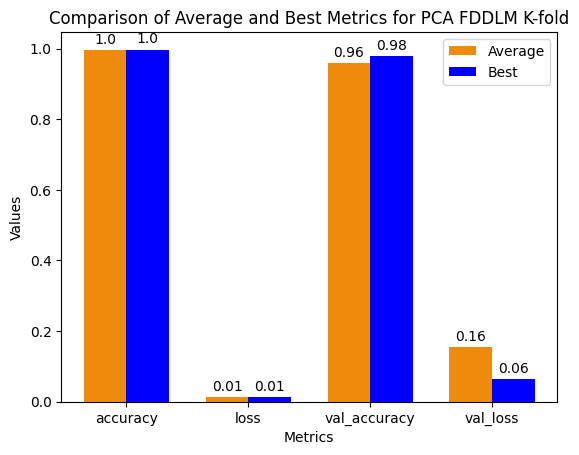

In [40]:
get_history_summary(fddlm_history,"PCA FDDLM K-fold")

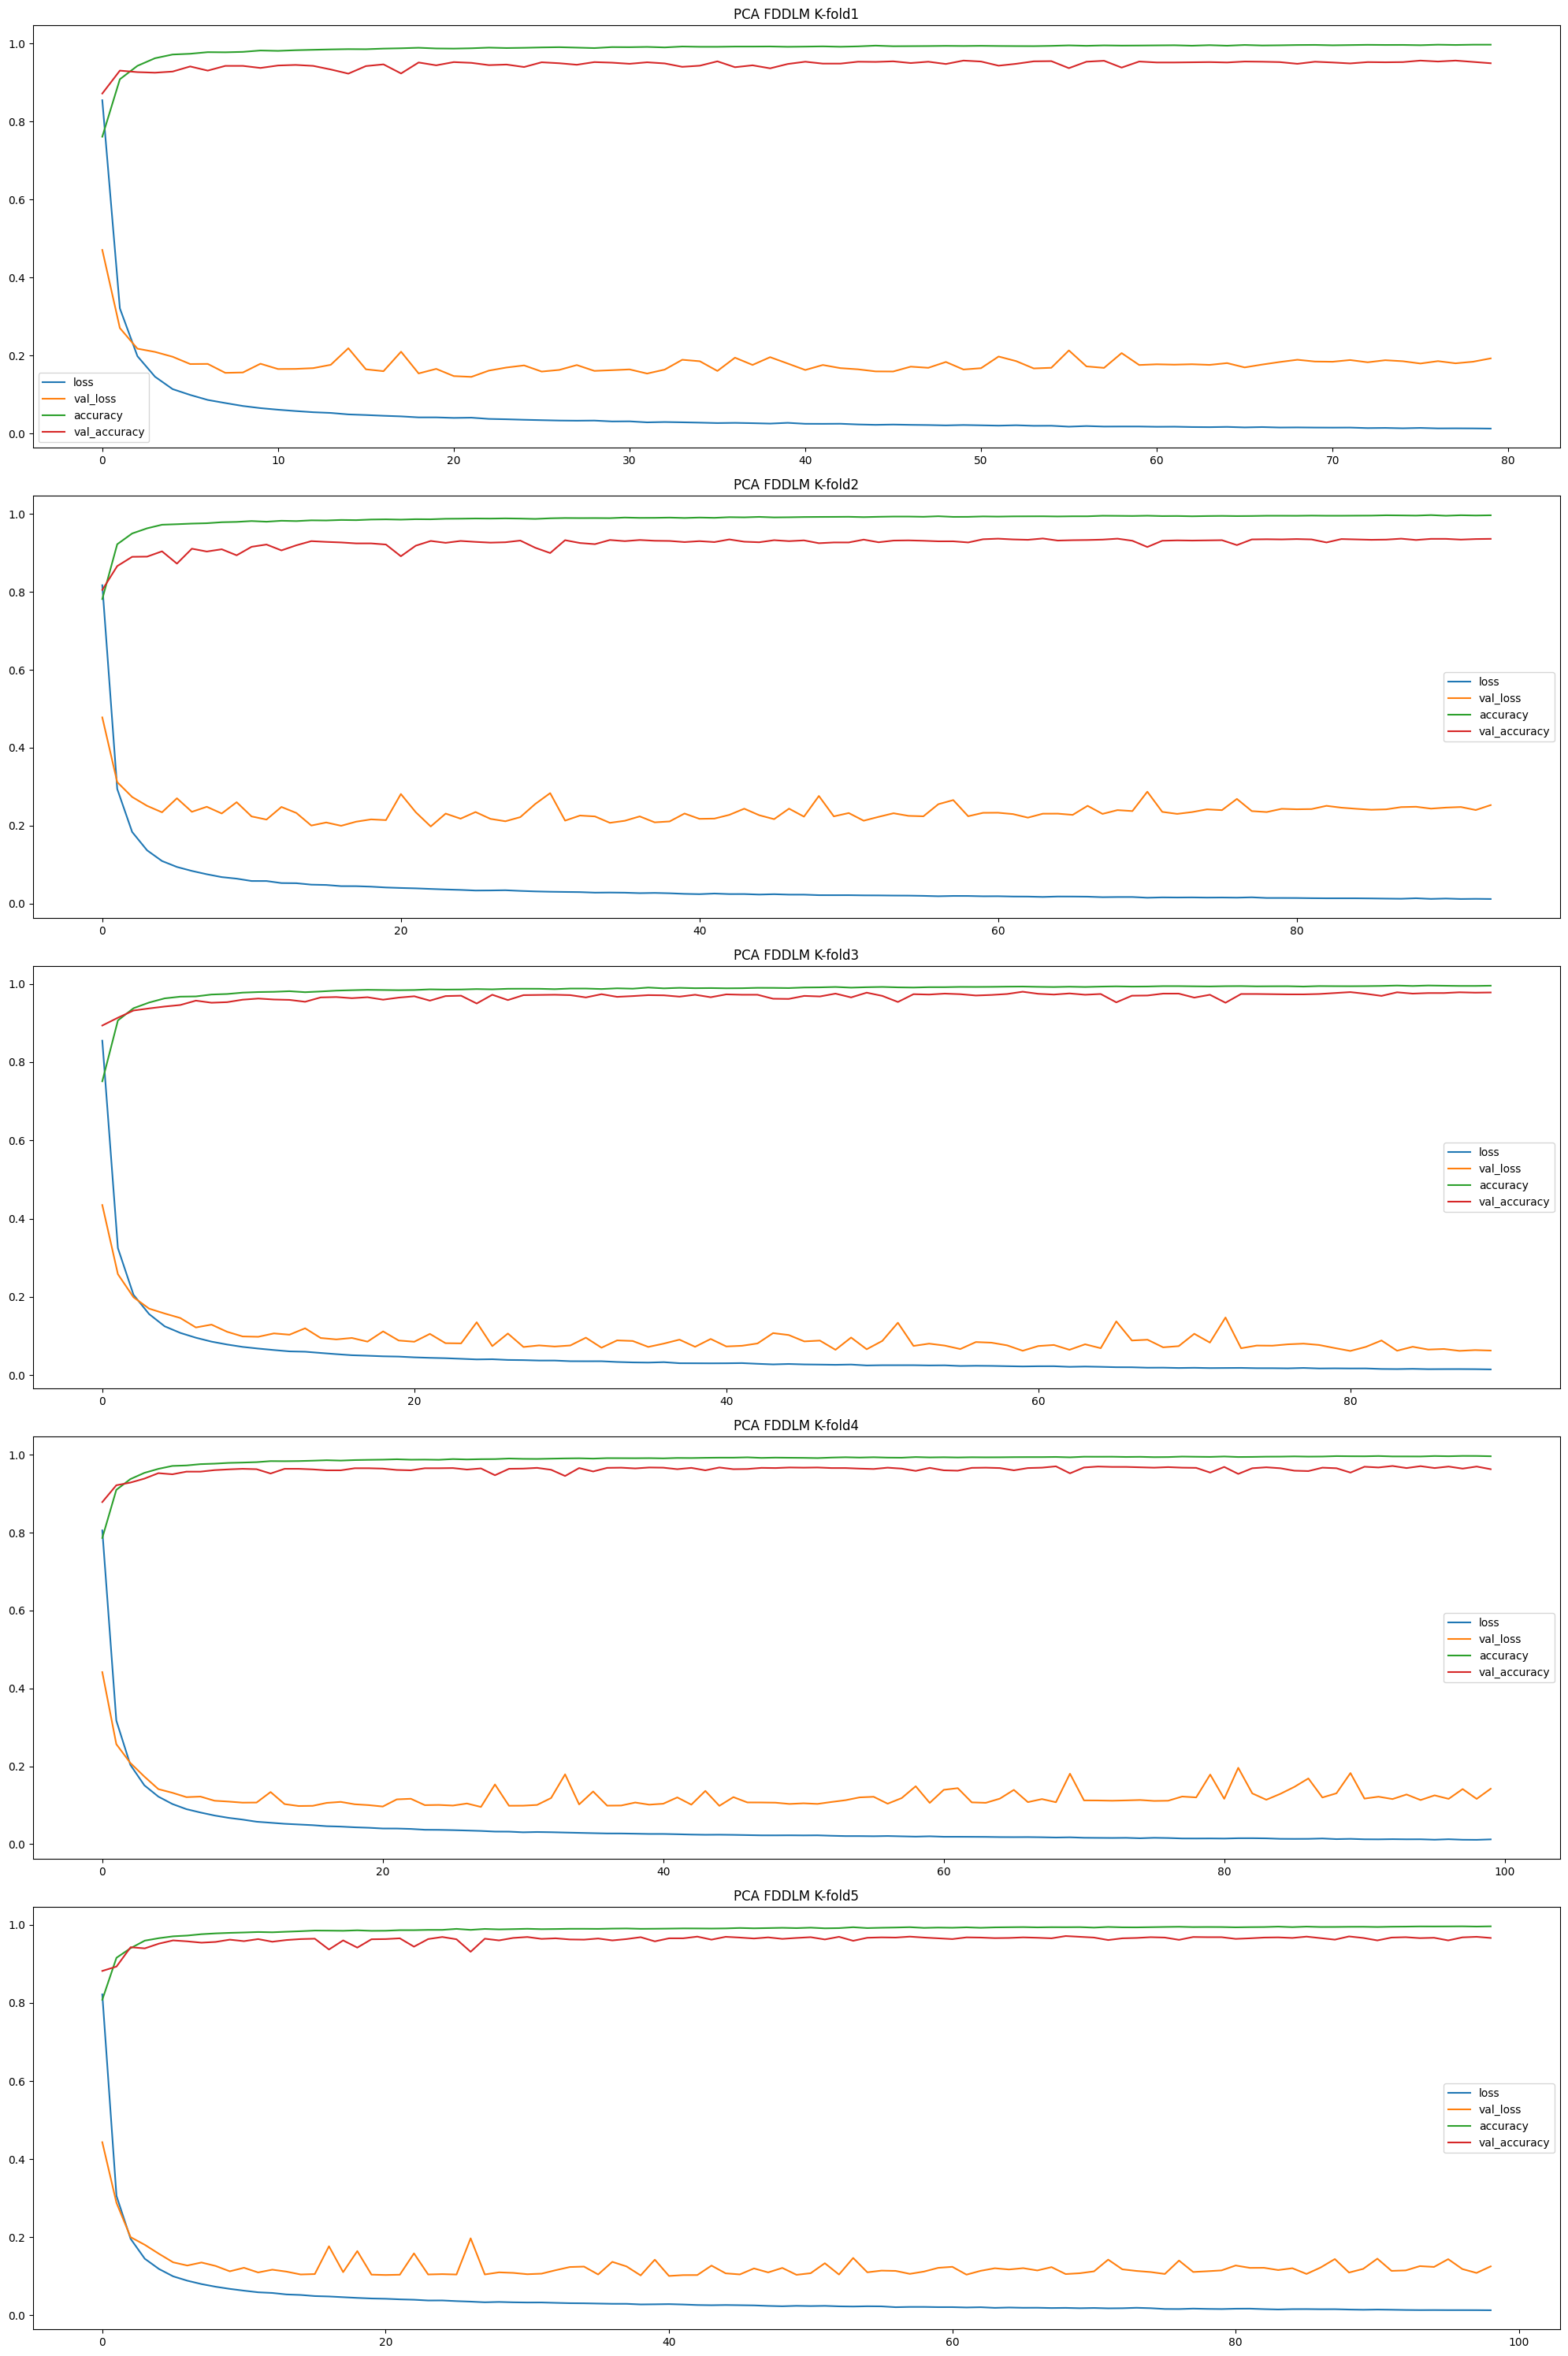

In [41]:
graph_drawing(fddlm_history,"PCA FDDLM K-fold")

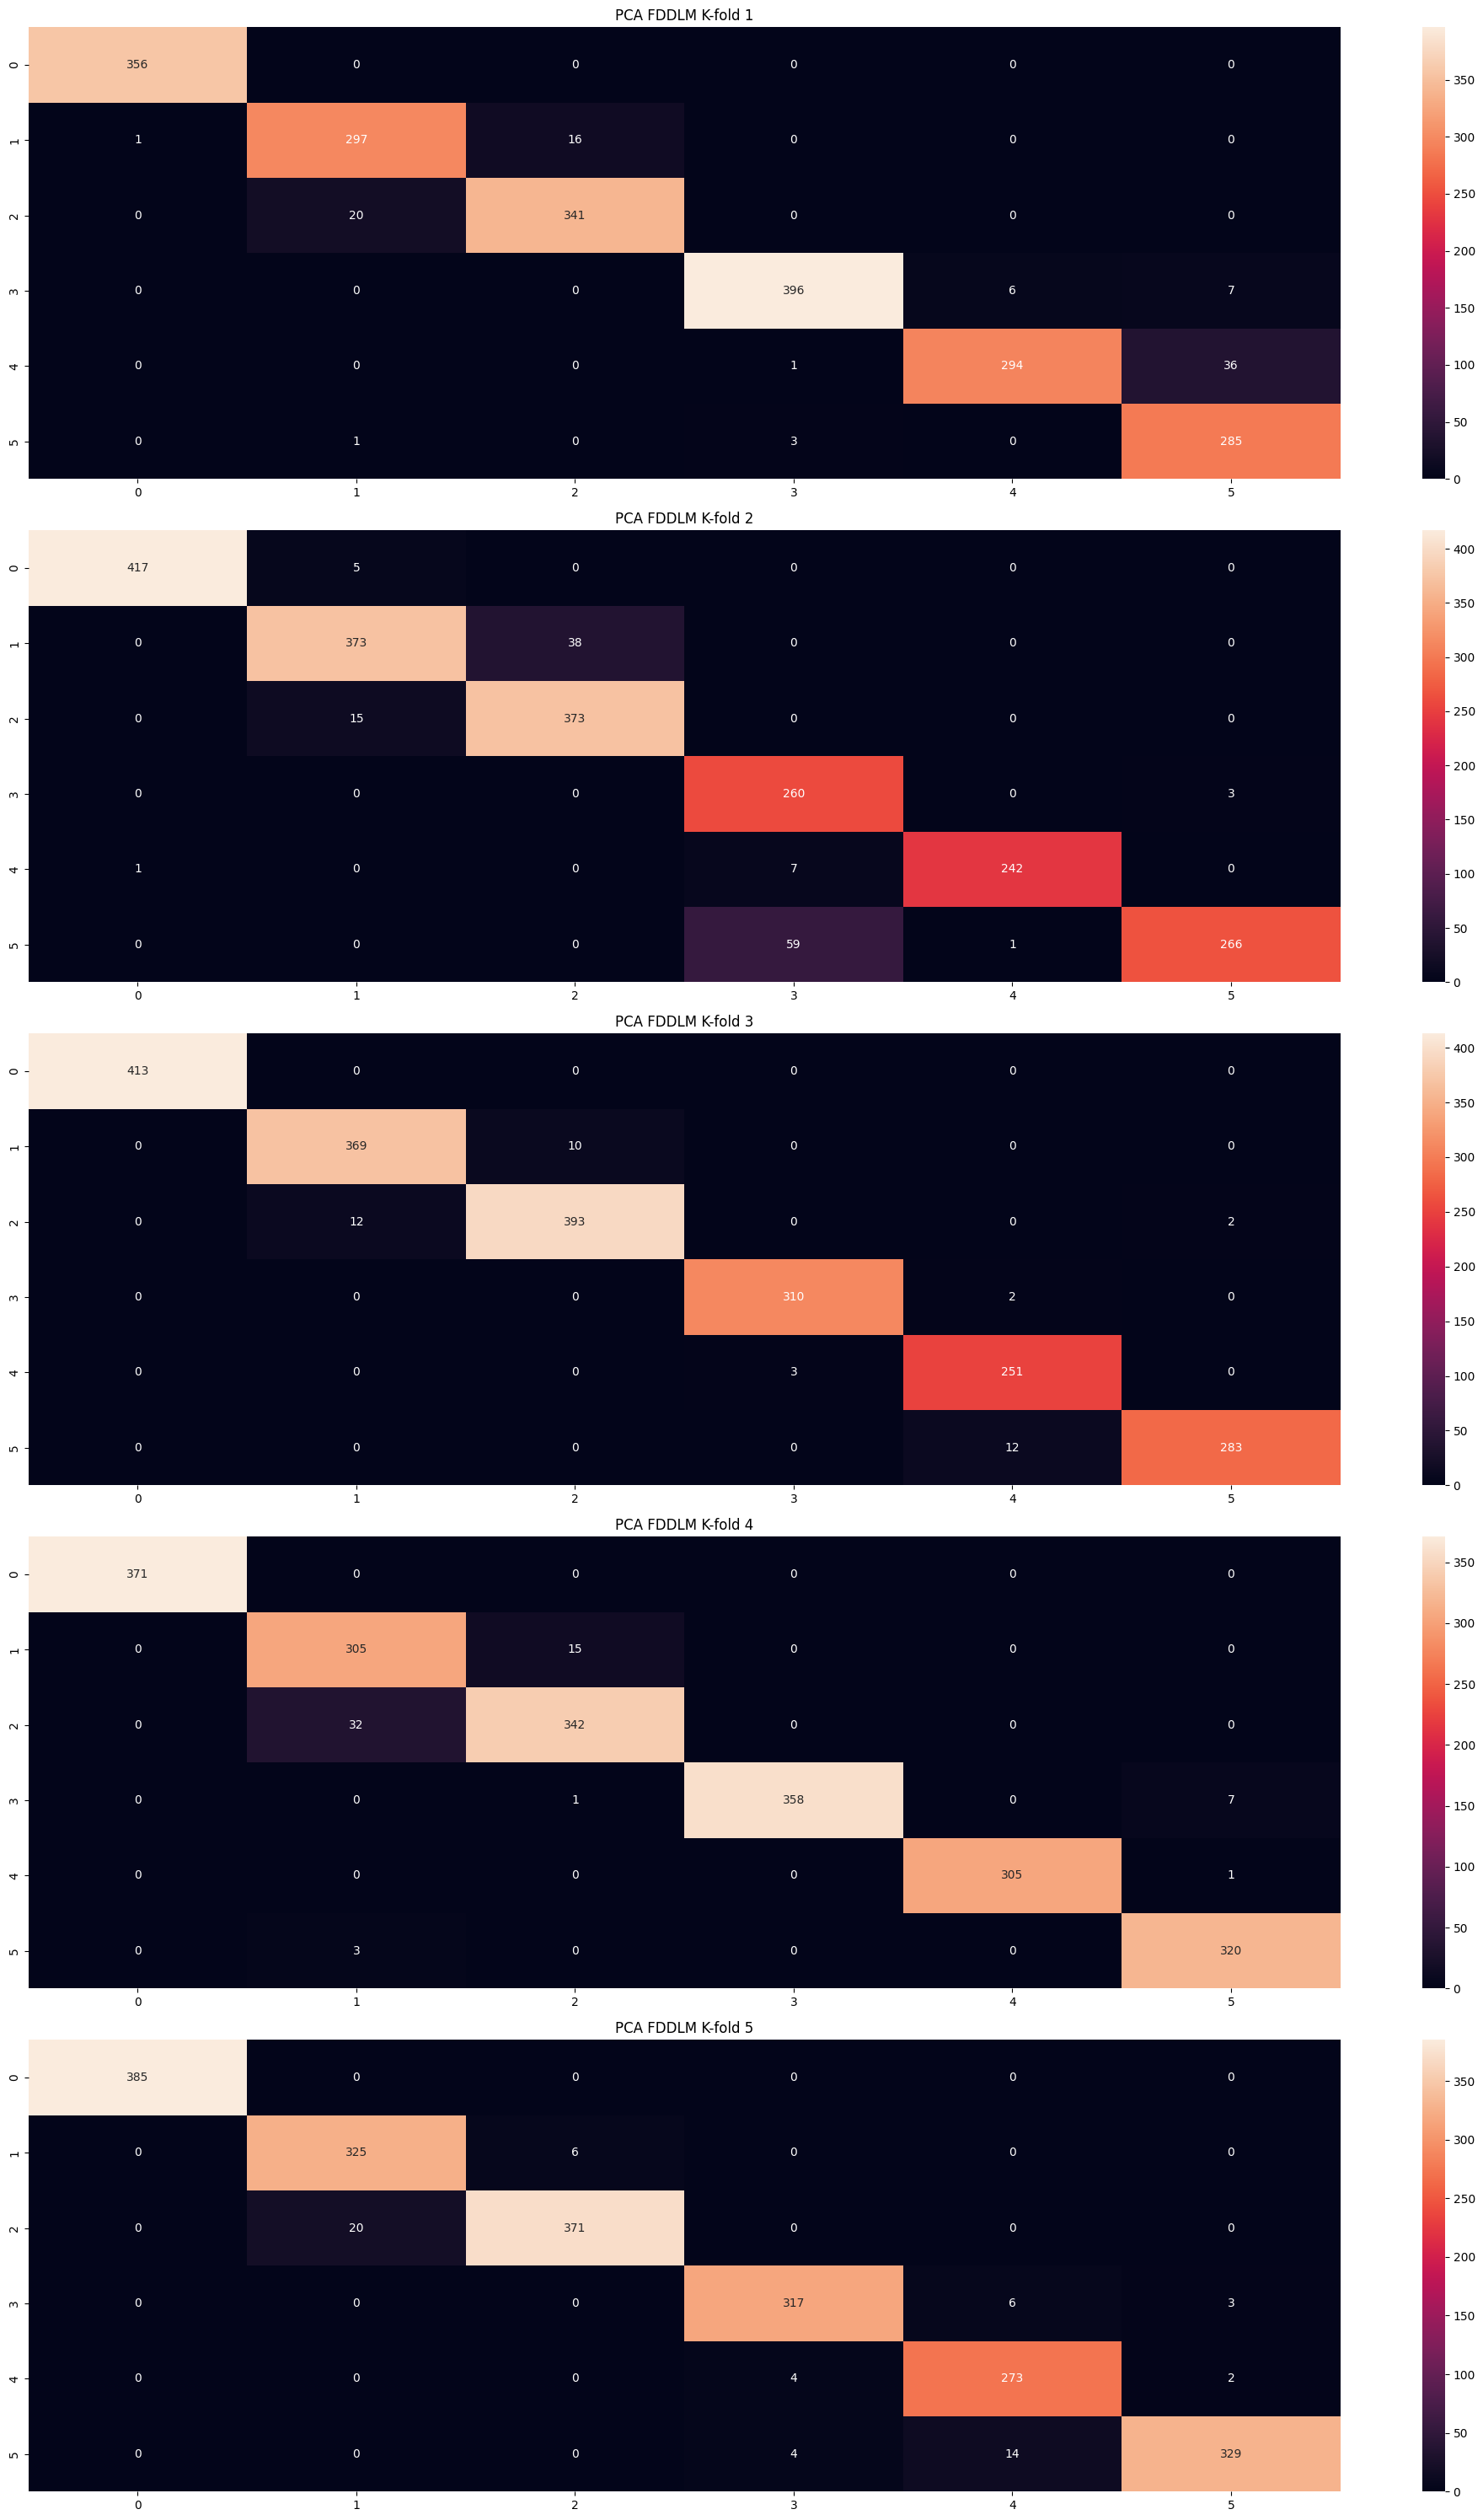

In [42]:
heatmap_drawing(fddlm_confusion_matrices,"PCA FDDLM K-fold")